In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
plt.style.use('seaborn')
plt.rc("font", family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

# 프로젝트 1차 EDA

 - 주제 : LOL 매치 데이터를 바탕으로 승패를 가려낼 수 있다.
     * 승패 예측에 주효한 변수가 존재할까?
     * (추가) 경기 시간에 따라 승패 예측 모델이 다르게 나타날 수 있을까?
     * (추가) 주요 변수의 분산은 승패 예측에 얼마나 영향력을 미칠까? >> 팀 내에서 특정 플레이어만 돋보일 경우 승리에 해가 될까?

## 데이터셋

 - League of Legends(LOL) - Ranked Games 2020
 - challenger,grandmaster,master 108,000 game data
 - 데이터 출처 : https://www.kaggle.com/gyejr95/league-of-legendslol-ranked-games-2020-ver1
 - 데이터 출처 : https://developer.riotgames.com/apis#match-v4
 
### 사용 데이터 설명
     - match_data_version1.pickle : 매치 관련 데이터
     - match_winner_data_version1.pickle : 승자 데이터
     - match_loser_data_version1.pickle : 패자 데이터

####  match 데이터

##### 데이터 읽기

In [4]:
raw_df = pd.read_pickle('data/match_data_version1.pickle')
raw_df.shape

(108829, 14)

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
raw_df.head()

gameCreation  gameDuration        gameId gameMode      gameType  \
0 1585154663829.00       1323.00 4247263043.00  CLASSIC  MATCHED_GAME   
1 1585152108929.00       1317.00 4247155821.00  CLASSIC  MATCHED_GAME   
2 1585059026141.00        932.00 4243963257.00  CLASSIC  MATCHED_GAME   
3 1584977993720.00       2098.00 4241678498.00  CLASSIC  MATCHED_GAME   
4 1584973382886.00       2344.00 4241538868.00  CLASSIC  MATCHED_GAME   

     gameVersion  mapId                              participantIdentities  \
0  10.6.314.4405  11.00  [{'participantId': 1, 'player': {'platformId':...   
1  10.6.314.4405  11.00  [{'participantId': 1, 'player': {'platformId':...   
2  10.6.313.8894  11.00  [{'participantId': 1, 'player': {'platformId':...   
3  10.6.313.8894  11.00  [{'participantId': 1, 'player': {'platformId':...   
4  10.6.313.8894  11.00  [{'participantId': 1, 'player': {'platformId':...   

                                        participants platformId  queueId  \
0  [{'participantId': 1, 'teamId': 100, 'champion...         KR   420.00   
1  [{'participantId': 1, 'teamId': 100, 'champion...         KR   420.00   
2  [{'participantId': 1, 'teamId': 100, 'champion...         KR   420.00   
3  [{'participantId': 1, 'teamId': 100, 'champion...         KR   420.00   
4  [{'participantId': 1, 'teamId': 100, 'champion...         KR   420.00   

   seasonId status.message  status.status_code  
0     13.00            NaN                 nan  
1     13.00            NaN                 nan  
2     13.00            NaN                 nan  
3     13.00            NaN                 nan  
4     13.00            NaN                 nan

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108829 entries, 0 to 0
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   gameCreation           108829 non-null  float64
 1   gameDuration           108829 non-null  float64
 2   gameId                 108829 non-null  float64
 3   gameMode               108829 non-null  object 
 4   gameType               108829 non-null  object 
 5   gameVersion            108829 non-null  object 
 6   mapId                  108829 non-null  float64
 7   participantIdentities  108829 non-null  object 
 8   participants           108829 non-null  object 
 9   platformId             108829 non-null  object 
 10  queueId                108829 non-null  float64
 11  seasonId               108829 non-null  float64
 12  status.message         0 non-null       object 
 13  status.status_code     0 non-null       float64
dtypes: float64(7), object(7)
memory usage: 12

##### 테이블 정보
 * gameCreation : 게임 생성번호
 * gameDuration : 게임 진행시간 (단위 : 초)
 * gameId : 게임(매치) 고유값
 * gameMode : 게임 모드
 * gameType : 게임 종류(TFT, Classic, URF 등, 현 분석에서는 Classic 만 사용할 예정)
 * gameVersion : 클라이언트의 버전
 * mapId : 맵 구분
 * participantIdentities : 플레이어 정보 (dict) 
 * participants : 플레이어 당 플레이 데이터 (dict)
 * platformId : 서버의 국가
 * queueId : team간의 게임이 성사된 id
 * seasonId : 시즌 번호
 * status.message : --
 * status.status_code : --
 * gameCreation : 듀오나 솔로 등의 상태로 참여 시 생성되는 번호로 유추되나 이번 분석에서는 사용하지 않음

##### gameDuration feature

* gameDuration : 게임 지속 시간(초)으로 다음과 같은 구분점을 가짐
  - <= 400 : 180 초 이후 플레이어의 게임 참여 상황에 따라 게임을 초기화 할 수 있고, 게임이 성립되지 않아 종료된 게임으로 판단
  - 400 < x <= 1020 : 900초 이후 한 쪽의 항복 선언으로 게임 종료가 가능하고, 해당 투표가 2번까지 진행되는 1020초까지 단기에 결판난 게임으로 판단
  - < 1020 : 중장기전으로 분류

Text(0.5, 1.0, 'gameDuration')

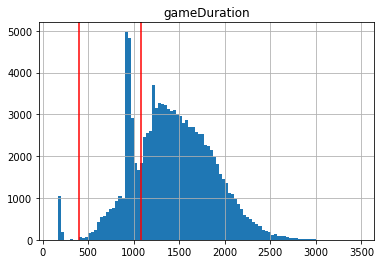

In [5]:
raw_df['gameDuration'].hist(bins= 100)

plt.ylim(0,5200)
plt.plot([400,400],[0,5200], 'r-')
plt.plot([1080,1080],[0,5200], 'r-')
plt.title('gameDuration')

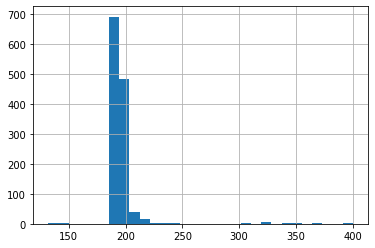

In [8]:
raw_df[raw_df['gameDuration'] <= 400]['gameDuration'].hist(bins = 30)

In [8]:
raw_df[raw_df['gameDuration'] <= 400]['gameId'].count() / 108829

0.011632928723042571

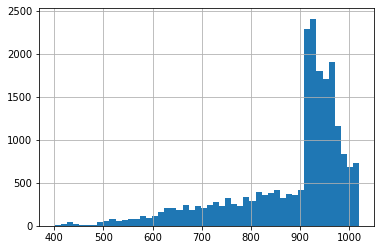

In [9]:
raw_df[(raw_df['gameDuration'] > 400) & (raw_df['gameDuration'] <= 1020)]['gameDuration'].hist(bins = 50)

In [9]:
raw_df[(raw_df['gameDuration'] > 400) &(raw_df['gameDuration'] <= 1020)]['gameId'].count() / 108829

0.19501235883817733

##### 미사용 변수들
* gameType : 단일 값으로 분석에 미사용

In [10]:
print("gameMode 'CLASSIC': {0}".format(92857 / 108770)) ## 클래식 모드만 남기는 걸로

raw_df['gameType'].value_counts()

gameMode 'CLASSIC': 0.8537004688792865


MATCHED_GAME    108829
Name: gameType, dtype: int64

In [6]:
raw_df['gameCreation'].value_counts()

1584360151678.00    2
1581487345709.00    2
1581316019069.00    2
1584815530903.00    2
1583572999175.00    2
                   ..
1583440784595.00    1
1574854371100.00    1
1583447843795.00    1
1567319881644.00    1
1580551189560.00    1
Name: gameCreation, Length: 108770, dtype: int64

* gameMode : 85%의 비중을 차지하는 CLASSIC 모드만 분석

In [11]:
raw_df['gameMode'].value_counts()

CLASSIC              92857
ARAM                 12061
URF                   2196
ONEFORALL             1575
KINGPORO               122
TUTORIAL_MODULE_1       12
TUTORIAL_MODULE_3        3
TUTORIAL_MODULE_2        3
Name: gameMode, dtype: int64

* mapId : 전체의 88.8% 에 해당하는 11 번 맵만 분석에 활용 (LOL rank game)

In [12]:
print("mapId 11: {0}".format(96640 / 108829))
raw_df['mapId'].value_counts() ## 88.8% 에 해당하는 11번 맵만 분석

mapId 11: 0.887998603313455


11.00    96640
12.00    12183
10.00        6
Name: mapId, dtype: int64

In [13]:
raw_df['participantIdentities'][1]

[{'participantId': 1,
  'player': {'platformId': 'KR',
   'accountId': 'F23ggf384dqSm_YjnKOXZ6AzT9AIuXnBae39fTdobe-8k7dHMULcr139',
   'summonerName': 'LPL Player',
   'summonerId': 'H5upZv7VdqopzqhvJWsAyMPm4KiuqCH7PMBlc4QLW4UUQY4',
   'currentPlatformId': 'KR',
   'currentAccountId': 'F23ggf384dqSm_YjnKOXZ6AzT9AIuXnBae39fTdobe-8k7dHMULcr139',
   'matchHistoryUri': '/v1/stats/player_history/KR/2372714339454208',
   'profileIcon': 29}},
 {'participantId': 2,
  'player': {'platformId': 'KR',
   'accountId': 'k9fNBRC8yXeqIJg2X3Tq3Ko2YuxFUd4fRfFSqC0Glyyk3Ds',
   'summonerName': 'GIDE0N',
   'summonerId': 'VRJ3UE5P3xbH7fAWhVv8teJ3vEDmYmTv9TCq59iZRrxdld0',
   'currentPlatformId': 'KR',
   'currentAccountId': 'k9fNBRC8yXeqIJg2X3Tq3Ko2YuxFUd4fRfFSqC0Glyyk3Ds',
   'matchHistoryUri': '/v1/stats/player_history/KR/210316631',
   'profileIcon': 25}},
 {'participantId': 3,
  'player': {'platformId': 'KR',
   'accountId': 'bVwP9CQfYvmYu0L_U7p5NCo14wsHOoRfbrnpvGBBPyp32M0',
   'summonerName': 'supupsupu

##### 주요 데이터 컬럼

In [14]:
raw_df['participants'][1]

[{'participantId': 1,
  'teamId': 100,
  'championId': 236,
  'spell1Id': 14,
  'spell2Id': 4,
  'stats': {'participantId': 1,
   'win': True,
   'item0': 2422,
   'item1': 3153,
   'item2': 3071,
   'item3': 1055,
   'item4': 1042,
   'item5': 1055,
   'item6': 3363,
   'kills': 3,
   'deaths': 5,
   'assists': 2,
   'largestKillingSpree': 2,
   'largestMultiKill': 1,
   'killingSprees': 1,
   'longestTimeSpentLiving': 351,
   'doubleKills': 0,
   'tripleKills': 0,
   'quadraKills': 0,
   'pentaKills': 0,
   'unrealKills': 0,
   'totalDamageDealt': 91081,
   'magicDamageDealt': 3316,
   'physicalDamageDealt': 83719,
   'trueDamageDealt': 4045,
   'largestCriticalStrike': 0,
   'totalDamageDealtToChampions': 16662,
   'magicDamageDealtToChampions': 916,
   'physicalDamageDealtToChampions': 15033,
   'trueDamageDealtToChampions': 712,
   'totalHeal': 1267,
   'totalUnitsHealed': 1,
   'damageSelfMitigated': 5791,
   'damageDealtToObjectives': 1885,
   'damageDealtToTurrets': 1885,
   'v

#### Winner / Loser 데이터

In [3]:
winner_df = pd.read_pickle('data/match_winner_data_version1.pickle')
winner_df.shape

(108829, 17)

* teamId : 팀 구분
* win : 승리 여부
* firstBlood : 먼저 적을 사망하게 했는지 여부
* first___ : 먼저 특정 종류의 오브젝트를 사냥했는지의 여부
* __ Kills : 특정 오브젝트를 사냥한 숫자

In [16]:
winner_df.head()

teamId  win  firstBlood  firstTower  firstInhibitor  firstBaron  \
0     200  Win       False        True            True       False   
1     100  Win       False       False           False       False   
2     200  Win        True        True            True       False   
3     200  Win        True        True           False       False   
4     100  Win        True        True            True        True   

   firstDragon  firstRiftHerald  towerKills  inhibitorKills  baronKills  \
0         True             True           9               1           0   
1         True             True           4               0           0   
2         True             True           5               1           0   
3        False             True           6               0           1   
4         True             True          11               3           2   

   dragonKills  vilemawKills  riftHeraldKills  dominionVictoryScore  \
0            3             0                2                     0   
1            2             0                2                     0   
2            2             0                2                     0   
3            3             0                1                     0   
4            2             0                2                     0   

                                                bans        gameId  
0  [{'championId': 523, 'pickTurn': 6}, {'champio... 4247263043.00  
1  [{'championId': 523, 'pickTurn': 1}, {'champio... 4247155821.00  
2  [{'championId': 350, 'pickTurn': 6}, {'champio... 4243963257.00  
3  [{'championId': 81, 'pickTurn': 6}, {'champion... 4241678498.00  
4  [{'championId': 30, 'pickTurn': 1}, {'champion... 4241538868.00

In [17]:
pd.DataFrame(winner_df['bans'][0])

championId  pickTurn
0         523         6
1         429         7
2         142         8
3          62         9
4          -1        10

In [4]:
loser_df = pd.read_pickle('data/match_loser_data_version1.pickle')
loser_df.shape

(108829, 17)

In [19]:
loser_df.head()

teamId   win  firstBlood  firstTower  firstInhibitor  firstBaron  \
0     100  Fail        True       False           False       False   
1     200  Fail        True        True           False       False   
2     100  Fail       False       False           False       False   
3     100  Fail       False       False           False        True   
4     200  Fail       False       False           False       False   

   firstDragon  firstRiftHerald  towerKills  inhibitorKills  baronKills  \
0        False            False           0               0           0   
1        False            False           2               0           0   
2        False            False           0               0           0   
3         True            False           2               0           1   
4        False            False           6               1           1   

   dragonKills  vilemawKills  riftHeraldKills  dominionVictoryScore  \
0            0             0                0                     0   
1            0             0                0                     0   
2            0             0                0                     0   
3            1             0                0                     0   
4            3             0                0                     0   

                                                bans        gameId  
0  [{'championId': -1, 'pickTurn': 1}, {'champion... 4247263043.00  
1  [{'championId': 875, 'pickTurn': 6}, {'champio... 4247155821.00  
2  [{'championId': 110, 'pickTurn': 1}, {'champio... 4243963257.00  
3  [{'championId': 523, 'pickTurn': 1}, {'champio... 4241678498.00  
4  [{'championId': 523, 'pickTurn': 6}, {'champio... 4241538868.00

## 데이터 전처리

### match 테이블 전처리

 * 불필요한 컬럼 삭제
 * participants 컬럼 내 플레이어 데이터를 컬럼으로 데이터 프레임화 하기

In [11]:
# match 테이블에서 분석에 사용할 컬럼을 선정
match_col = ['gameDuration', 'gameId','participants']

In [12]:
match_df = raw_df[(raw_df['gameMode'] == 'CLASSIC') & (raw_df['mapId'] == 11)][match_col].reset_index(drop=True)
match_df.shape

(92851, 3)

In [22]:
match_df

gameDuration        gameId  \
0           1323.00 4247263043.00   
1           1317.00 4247155821.00   
2            932.00 4243963257.00   
3           2098.00 4241678498.00   
4           2344.00 4241538868.00   
...             ...           ...   
92846        934.00 4039738326.00   
92847       1418.00 4170286047.00   
92848        933.00 4136207327.00   
92849       1544.00 4130964458.00   
92850       2090.00 4119954410.00   

                                            participants  
0      [{'participantId': 1, 'teamId': 100, 'champion...  
1      [{'participantId': 1, 'teamId': 100, 'champion...  
2      [{'participantId': 1, 'teamId': 100, 'champion...  
3      [{'participantId': 1, 'teamId': 100, 'champion...  
4      [{'participantId': 1, 'teamId': 100, 'champion...  
...                                                  ...  
92846  [{'participantId': 1, 'teamId': 100, 'champion...  
92847  [{'participantId': 1, 'teamId': 100, 'champion...  
92848  [{'participantId': 1, 'teamId': 100, 'champion...  
92849  [{'participantId': 1, 'teamId': 100, 'champion...  
92850  [{'participantId': 1, 'teamId': 100, 'champion...  

[92851 rows x 3 columns]

In [23]:
# 데이터가 많아서 원활한 테스트를 위한 테스트 데이터 생성
# test_df = match_df.sample(frac = 0.3, ignore_index=True).copy()
# test_df.shape

In [24]:
match_df.head()

gameDuration        gameId  \
0       1323.00 4247263043.00   
1       1317.00 4247155821.00   
2        932.00 4243963257.00   
3       2098.00 4241678498.00   
4       2344.00 4241538868.00   

                                        participants  
0  [{'participantId': 1, 'teamId': 100, 'champion...  
1  [{'participantId': 1, 'teamId': 100, 'champion...  
2  [{'participantId': 1, 'teamId': 100, 'champion...  
3  [{'participantId': 1, 'teamId': 100, 'champion...  
4  [{'participantId': 1, 'teamId': 100, 'champion...

#### participants 데이터를 살려보자

In [25]:
pd.DataFrame(match_df['participants'][0])

participantId  teamId  championId  spell1Id  spell2Id  \
0              1     100           7         1         4   
1              2     100         350         3         7   
2              3     100         266         4        12   
3              4     100         517         4        11   
4              5     100         110         4        21   
5              6     200         235         1         4   
6              7     200          81         7         4   
7              8     200         127         4        12   
8              9     200          84         4        12   
9             10     200         421        11         4   

                                               stats  \
0  {'participantId': 1, 'win': False, 'item0': 20...   
1  {'participantId': 2, 'win': False, 'item0': 31...   
2  {'participantId': 3, 'win': False, 'item0': 10...   
3  {'participantId': 4, 'win': False, 'item0': 31...   
4  {'participantId': 5, 'win': False, 'item0': 20...   
5  {'participantId': 6, 'win': True, 'item0': 386...   
6  {'participantId': 7, 'win': True, 'item0': 314...   
7  {'participantId': 8, 'win': True, 'item0': 203...   
8  {'participantId': 9, 'win': True, 'item0': 314...   
9  {'participantId': 10, 'win': True, 'item0': 0,...   

                                            timeline  
0  {'participantId': 1, 'creepsPerMinDeltas': {'1...  
1  {'participantId': 2, 'creepsPerMinDeltas': {'1...  
2  {'participantId': 3, 'creepsPerMinDeltas': {'1...  
3  {'participantId': 4, 'creepsPerMinDeltas': {'1...  
4  {'participantId': 5, 'creepsPerMinDeltas': {'1...  
5  {'participantId': 6, 'creepsPerMinDeltas': {'1...  
6  {'participantId': 7, 'creepsPerMinDeltas': {'1...  
7  {'participantId': 8, 'creepsPerMinDeltas': {'1...  
8  {'participantId': 9, 'creepsPerMinDeltas': {'1...  
9  {'participantId': 10, 'creepsPerMinDeltas': {'...

In [26]:
## participants Column dict 에서 사용할 컬럼
pt_cols = ['participantId','teamId','championId','stats']

In [27]:
pd.DataFrame(pd.DataFrame(match_df['participants'][0])['stats'])

stats
0  {'participantId': 1, 'win': False, 'item0': 20...
1  {'participantId': 2, 'win': False, 'item0': 31...
2  {'participantId': 3, 'win': False, 'item0': 10...
3  {'participantId': 4, 'win': False, 'item0': 31...
4  {'participantId': 5, 'win': False, 'item0': 20...
5  {'participantId': 6, 'win': True, 'item0': 386...
6  {'participantId': 7, 'win': True, 'item0': 314...
7  {'participantId': 8, 'win': True, 'item0': 203...
8  {'participantId': 9, 'win': True, 'item0': 314...
9  {'participantId': 10, 'win': True, 'item0': 0,...

* match_df >> participants >> stats

In [28]:
## stat dict 에서 사용할 컬럼
stat_cols = ['participantId', 'win',
        "kills",
        "visionScore",
        #"timeCCingOthers", "totalTimeCrowdControlDealt",
        "goldEarned", "goldSpent",
        #"totalMinionsKilled", "neutralMinionsKilled",
        "champLevel"]
        #"wardsPlaced", "wardsKilled"]

In [29]:
## stat 컬럼명 축소
stat_cols_convert = ['participantId', 'win',
        "kill",
        "vision",
        #"timeCC", "tTimeCC",
        "goldE", "goldS",
        #"minionK", "nMinionK",
        "champLv",
        #"wardsP", "wardsK"
        ]

In [8]:
pt_df = pd.DataFrame(raw_df['participants'][51])
pt_df

participantId  teamId  championId  spell1Id  spell2Id  \
0              1     100          58        12         4   
1              2     100          55        14         4   
2              3     100         154        14         4   
3              4     100          76        11         4   
4              5     100         110         7         4   
5              6     200          68         4        12   
6              7     200          38        12         4   
7              8     200          21         7         4   
8              9     200         516        14         4   
9             10     200          64        11         4   

                                               stats  \
0  {'participantId': 1, 'win': False, 'item0': 30...   
1  {'participantId': 2, 'win': False, 'item0': 30...   
2  {'participantId': 3, 'win': False, 'item0': 24...   
3  {'participantId': 4, 'win': False, 'item0': 20...   
4  {'participantId': 5, 'win': False, 'item0': 31...   
5  {'participantId': 6, 'win': True, 'item0': 315...   
6  {'participantId': 7, 'win': True, 'item0': 300...   
7  {'participantId': 8, 'win': True, 'item0': 105...   
8  {'participantId': 9, 'win': True, 'item0': 385...   
9  {'participantId': 10, 'win': True, 'item0': 24...   

                                            timeline  
0  {'participantId': 1, 'creepsPerMinDeltas': {'1...  
1  {'participantId': 2, 'creepsPerMinDeltas': {'1...  
2  {'participantId': 3, 'creepsPerMinDeltas': {'1...  
3  {'participantId': 4, 'creepsPerMinDeltas': {'1...  
4  {'participantId': 5, 'creepsPerMinDeltas': {'1...  
5  {'participantId': 6, 'creepsPerMinDeltas': {'1...  
6  {'participantId': 7, 'creepsPerMinDeltas': {'1...  
7  {'participantId': 8, 'creepsPerMinDeltas': {'1...  
8  {'participantId': 9, 'creepsPerMinDeltas': {'1...  
9  {'participantId': 10, 'creepsPerMinDeltas': {'...

In [9]:
temp = pt_df['stats'].apply(pd.Series)
# temp.columns = stat_cols_convert

temp

participantId    win  item0  item1  item2  item3  item4  item5  item6  \
0              1  False   3077   3071   3052   1054   1028   3111   3364   
1              2  False   3020   1026   1026   3146   1052   1082   3364   
2              3  False   2422   3211   3109   3859   2055      0   3364   
3              4  False   2031   1033   3108   1082   3158   1414   3364   
4              5  False   3153   1037   1052   1055   3006   1043   3363   
5              6   True   3151      0   3135   3020   1054   1028   3340   
6              7   True   3003      0      0   3111   3027   3041   3364   
7              8   True   1055   3508      0   1055   3006   3031   3363   
8              9   True   3855   3001   2031   3068   2422      0   3364   
9             10   True   2420   3071   1412   2055   3155   3111   3340   

   kills  ...  perk4Var3  perk5  perk5Var1  perk5Var2  perk5Var3  \
0      2  ...          0   8473        300          0          0   
1      4  ...          0   8014        179          0          0   
2      0  ...          0   8347          0          0          0   
3      0  ...          0   8232          3         10          0   
4      5  ...          0   8236         14          0          0   
5      5  ...          0   8233         13         50          0   
6      4  ...          0   8135       2587          5          0   
7      8  ...          0   8233         15         50          0   
8      4  ...          0   8347          0          0          0   
9      7  ...          0   8347          0          0          0   

   perkPrimaryStyle  perkSubStyle  statPerk0  statPerk1  statPerk2  
0              8000          8400       5008       5008       5002  
1              8100          8000       5008       5008       5003  
2              8400          8300       5007       5002       5003  
3              8100          8200       5005       5008       5002  
4              8000          8200       5005       5008       5002  
5              8100          8200       5008       5008       5002  
6              8000          8100       5008       5008       5003  
7              8000          8200       5005       5008       5002  
8              8400          8300       5007       5003       5002  
9              8000          8300       5005       5008       5003  

[10 rows x 102 columns]

* stats 데이터를 컬럼화 하여 원래의 participants 테이블에 merge

In [32]:
pt_df = pt_df.merge(temp, how='left', on='participantId')
pt_df

participantId  teamId  championId  \
0              1     100           7   
1              2     100         350   
2              3     100         266   
3              4     100         517   
4              5     100         110   
5              6     200         235   
6              7     200          81   
7              8     200         127   
8              9     200          84   
9             10     200         421   

                                               stats    win  kill  vision  \
0  {'participantId': 1, 'win': False, 'item0': 20...  False     3      14   
1  {'participantId': 2, 'win': False, 'item0': 31...  False     0      34   
2  {'participantId': 3, 'win': False, 'item0': 10...  False     4       8   
3  {'participantId': 4, 'win': False, 'item0': 31...  False     4      21   
4  {'participantId': 5, 'win': False, 'item0': 20...  False     4      14   
5  {'participantId': 6, 'win': True, 'item0': 386...   True    10      28   
6  {'participantId': 7, 'win': True, 'item0': 314...   True     4      16   
7  {'participantId': 8, 'win': True, 'item0': 203...   True     4      23   
8  {'participantId': 9, 'win': True, 'item0': 314...   True     6      17   
9  {'participantId': 10, 'win': True, 'item0': 0,...   True     7      36   

   goldE  goldS  champLv  
0   6844   6710       12  
1   5205   5212       10  
2   8226   7300       13  
3   7911   7770       11  
4   8815   8855       10  
5   9802   8425       12  
6   9203   8075       12  
7  11127   8810       14  
8   9286   9375       13  
9  10414   7250       13

In [33]:
for col in temp :
    print(f'"{col}",')

"participantId",
"win",
"kill",
"vision",
"goldE",
"goldS",
"champLv",


In [34]:
teamId_agg = {
    'win' : 'mean',
    'kill' : 'sum',
    'vision' : 'sum',
#     'timeCC' : 'sum',
#     'tTimeCC' : 'sum',
    'goldE' : {'sum', 'std'},
    'goldS' : 'sum',
#     'minionK' : 'sum',
#     'nMinionK' : 'sum',
    'champLv' : {'mean', 'std'},
#     'wardsP' : 'sum',
#     'wardsK' : 'sum'}
    }
pt_agg_df = pt_df.groupby('teamId').agg(teamId_agg)

* 각 플레이어의 데이터를 양 팀의 데이터로 집계하여 표시

In [35]:
pt_agg_df

win kill vision  goldE          goldS champLv     
         mean  sum    sum    sum     std    sum    mean  std
teamId                                                      
100     False   15     91  37001 1420.63  35847   11.20 1.30
200      True   31    120  49832  809.33  41935   12.80 0.84

In [36]:
agg_cols = []

for col in pt_agg_df.columns :
    if col[0] in ['goldE', 'champLv']:
        agg_cols.append(col[0] + '_' + col[1])
    else :
        agg_cols.append(col[0]) 
    
agg_cols

['win',
 'kill',
 'vision',
 'goldE_sum',
 'goldE_std',
 'goldS',
 'champLv_mean',
 'champLv_std']

In [37]:
pt_agg_df.columns = agg_cols

In [38]:
pt_agg_df

win  kill  vision  goldE_sum  goldE_std  goldS  champLv_mean  \
teamId                                                                   
100     False    15      91      37001    1420.63  35847         11.20   
200      True    31     120      49832     809.33  41935         12.80   

        champLv_std  
teamId               
100            1.30  
200            0.84

* 양팀의 데이터를 다시 게임 기준 한 개의 raw 로 치환하는 작업

In [39]:
team_100 = pt_agg_df.loc[[100]].reset_index(drop= True)
team_100.columns = '100_'+team_100.columns

team_200 = pt_agg_df.loc[[200]].reset_index(drop= True)
team_200.columns = '200_'+team_200.columns

In [40]:
team_100

100_win  100_kill  100_vision  100_goldE_sum  100_goldE_std  100_goldS  \
0    False        15          91          37001        1420.63      35847   

   100_champLv_mean  100_champLv_std  
0             11.20             1.30

In [41]:
pd.concat([team_100, team_200], axis = 1)

100_win  100_kill  100_vision  100_goldE_sum  100_goldE_std  100_goldS  \
0    False        15          91          37001        1420.63      35847   

   100_champLv_mean  100_champLv_std  200_win  200_kill  200_vision  \
0             11.20             1.30     True        31         120   

   200_goldE_sum  200_goldE_std  200_goldS  200_champLv_mean  200_champLv_std  
0          49832         809.33      41935             12.80             0.84

* 위의 일련의 과정을 한 개의 함수로 변환

In [42]:
def get_stats(x) :
    pt_df = pd.DataFrame(x)[pt_cols]
    
    temp = pt_df['stats'].apply(pd.Series)[stat_cols]
    temp.columns = stat_cols_convert
    
    pt_df = pt_df.merge(temp, how='left', on='participantId')
    
    pt_agg_df = pt_df.groupby('teamId').agg(teamId_agg)    
    
    agg_cols = []

    for col in pt_agg_df.columns :
        if col[0] in ['goldE', 'champLv']:
            agg_cols.append(col[0] + '_' + col[1])
        else :
            agg_cols.append(col[0]) 
            
    pt_agg_df.columns = agg_cols
    
    team_100 = pt_agg_df.loc[[100]].reset_index(drop= True)
    team_100.columns = '100_'+team_100.columns

    team_200 = pt_agg_df.loc[[200]].reset_index(drop= True)
    team_200.columns = '200_'+team_200.columns
    
    return pd.concat([team_100, team_200], axis = 1)

* 다시 전체 데이터 프레임에 적용하여 전체 데이터를 변환하는 함수를 작성합니다.

In [43]:
def get_stats_df(df) :
    
    stats_df = pd.DataFrame()
    
    for i in range(df.shape[0]) :
        stats_df = stats_df.append(get_stats(df['participants'][i]))
        
    stats_df = stats_df.reset_index(drop=True)
        
    return stats_df

* match_df에 함수를 적용하여 사용할 데이터를 만들어냅니다.

In [44]:
stats_df = get_stats_df(match_df)
stats_df.shape

(92851, 16)

In [45]:
match_df.shape

(92851, 3)

In [46]:
stats_df.head()

100_win  100_kill  100_vision  100_goldE_sum  100_goldE_std  100_goldS  \
0    False        15          91          37001        1420.63      35847   
1     True        19         125          41072        1468.91      34960   
2    False         5          52          22929        1066.30      21985   
3    False        26         249          63447        2593.17      61925   
4     True        27         278          74955        2974.51      71580   

   100_champLv_mean  100_champLv_std  200_win  200_kill  200_vision  \
0             11.20             1.30     True        31         120   
1             12.60             1.14    False         8         111   
2              8.40             1.14     True        20          74   
3             16.00             1.22     True        36         243   
4             16.60             1.67    False        40         237   

   200_goldE_sum  200_goldE_std  200_goldS  200_champLv_mean  200_champLv_std  
0          49832         809.33      41935             12.80             0.84  
1          37136        1816.21      33600             11.80             2.17  
2          35364        1164.55      30755             10.00             1.00  
3          70528        3155.70      63893             16.80             1.10  
4          74596        2500.95      73910             17.00             0.71

* 분석에 사용할 메인 데이터 프레임 생성

In [47]:
sample_df = pd.concat([match_df, stats_df], axis = 1).drop(['participants'], axis = 1)

In [48]:
sample_df.head(5)

gameDuration        gameId  100_win  100_kill  100_vision  100_goldE_sum  \
0       1323.00 4247263043.00    False        15          91          37001   
1       1317.00 4247155821.00     True        19         125          41072   
2        932.00 4243963257.00    False         5          52          22929   
3       2098.00 4241678498.00    False        26         249          63447   
4       2344.00 4241538868.00     True        27         278          74955   

   100_goldE_std  100_goldS  100_champLv_mean  100_champLv_std  200_win  \
0        1420.63      35847             11.20             1.30     True   
1        1468.91      34960             12.60             1.14    False   
2        1066.30      21985              8.40             1.14     True   
3        2593.17      61925             16.00             1.22     True   
4        2974.51      71580             16.60             1.67    False   

   200_kill  200_vision  200_goldE_sum  200_goldE_std  200_goldS  \
0        31         120          49832         809.33      41935   
1         8         111          37136        1816.21      33600   
2        20          74          35364        1164.55      30755   
3        36         243          70528        3155.70      63893   
4        40         237          74596        2500.95      73910   

   200_champLv_mean  200_champLv_std  
0             12.80             0.84  
1             11.80             2.17  
2             10.00             1.00  
3             16.80             1.10  
4             17.00             0.71

###  winner / loser 테이블 전처리

- 각 게임의 승자와 패자로 테이블이 구분되어 있어서, 각 팀의 순서대로 데이터를 재구성할 필요가 있음.

 * winner / loser 테이블을 행 방향으로 합쳐서 하나의 테이블로 바꾼 후
 * 100 / 200 번 팀의 데이터로 각각의 테이블을 재배치 후
 * 열 방향으로 매치별 데이터를 형성

In [49]:
winner_df.head()

teamId  win  firstBlood  firstTower  firstInhibitor  firstBaron  \
0     200  Win       False        True            True       False   
1     100  Win       False       False           False       False   
2     200  Win        True        True            True       False   
3     200  Win        True        True           False       False   
4     100  Win        True        True            True        True   

   firstDragon  firstRiftHerald  towerKills  inhibitorKills  baronKills  \
0         True             True           9               1           0   
1         True             True           4               0           0   
2         True             True           5               1           0   
3        False             True           6               0           1   
4         True             True          11               3           2   

   dragonKills  vilemawKills  riftHeraldKills  dominionVictoryScore  \
0            3             0                2                     0   
1            2             0                2                     0   
2            2             0                2                     0   
3            3             0                1                     0   
4            2             0                2                     0   

                                                bans        gameId  
0  [{'championId': 523, 'pickTurn': 6}, {'champio... 4247263043.00  
1  [{'championId': 523, 'pickTurn': 1}, {'champio... 4247155821.00  
2  [{'championId': 350, 'pickTurn': 6}, {'champio... 4243963257.00  
3  [{'championId': 81, 'pickTurn': 6}, {'champion... 4241678498.00  
4  [{'championId': 30, 'pickTurn': 1}, {'champion... 4241538868.00

* 값이 없는 컬럼을 먼저 탈락 시킴

In [50]:
winner_df['dominionVictoryScore'].value_counts()

0    108829
Name: dominionVictoryScore, dtype: int64

In [51]:
# loser_df = pd.read_pickle('data/match_loser_data_version1.pickle')
loser_df.shape

(108829, 17)

In [52]:
loser_df.head()

teamId   win  firstBlood  firstTower  firstInhibitor  firstBaron  \
0     100  Fail        True       False           False       False   
1     200  Fail        True        True           False       False   
2     100  Fail       False       False           False       False   
3     100  Fail       False       False           False        True   
4     200  Fail       False       False           False       False   

   firstDragon  firstRiftHerald  towerKills  inhibitorKills  baronKills  \
0        False            False           0               0           0   
1        False            False           2               0           0   
2        False            False           0               0           0   
3         True            False           2               0           1   
4        False            False           6               1           1   

   dragonKills  vilemawKills  riftHeraldKills  dominionVictoryScore  \
0            0             0                0                     0   
1            0             0                0                     0   
2            0             0                0                     0   
3            1             0                0                     0   
4            3             0                0                     0   

                                                bans        gameId  
0  [{'championId': -1, 'pickTurn': 1}, {'champion... 4247263043.00  
1  [{'championId': 875, 'pickTurn': 6}, {'champio... 4247155821.00  
2  [{'championId': 110, 'pickTurn': 1}, {'champio... 4243963257.00  
3  [{'championId': 523, 'pickTurn': 1}, {'champio... 4241678498.00  
4  [{'championId': 523, 'pickTurn': 6}, {'champio... 4241538868.00

In [5]:
wl_df = pd.concat([winner_df,loser_df], axis = 0, ignore_index=True).drop(['dominionVictoryScore', 'vilemawKills','bans'], axis = 1)
wl_df.head()

teamId  win  firstBlood  firstTower  firstInhibitor  firstBaron  \
0     200  Win       False        True            True       False   
1     100  Win       False       False           False       False   
2     200  Win        True        True            True       False   
3     200  Win        True        True           False       False   
4     100  Win        True        True            True        True   

   firstDragon  firstRiftHerald  towerKills  inhibitorKills  baronKills  \
0         True             True           9               1           0   
1         True             True           4               0           0   
2         True             True           5               1           0   
3        False             True           6               0           1   
4         True             True          11               3           2   

   dragonKills  riftHeraldKills        gameId  
0            3                2 4247263043.00  
1            2                2 4247155821.00  
2            2                2 4243963257.00  
3            3                1 4241678498.00  
4            2                2 4241538868.00

In [6]:
cat_100 = wl_df[wl_df['teamId'] == 100].drop('teamId', axis = 1).set_index('gameId')
cat_100.columns = '100_' + cat_100.columns
cat_200 = wl_df[wl_df['teamId'] == 200].drop('teamId', axis = 1).set_index('gameId')
cat_200.columns = '200_' + cat_200.columns

cat_df = cat_100.merge(cat_200, how='inner', on='gameId')

In [7]:
cat_df

100_win  100_firstBlood  100_firstTower  100_firstInhibitor  \
gameId                                                                      
4247155821.00     Win           False           False               False   
4241538868.00     Win            True            True                True   
4241394461.00     Win            True            True                True   
4233113995.00     Win            True            True                True   
4231100932.00     Win            True            True                True   
...               ...             ...             ...                 ...   
4048126927.00    Fail           False           False               False   
4222190547.00    Fail            True            True                True   
4061758422.00    Fail           False           False               False   
4039738326.00    Fail           False           False               False   
4177101793.00    Fail           False           False               False   

               100_firstBaron  100_firstDragon  100_firstRiftHerald  \
gameId                                                                
4247155821.00           False             True                 True   
4241538868.00            True             True                 True   
4241394461.00           False            False                 True   
4233113995.00            True            False                False   
4231100932.00            True            False                 True   
...                       ...              ...                  ...   
4048126927.00           False            False                 True   
4222190547.00            True             True                False   
4061758422.00           False            False                False   
4039738326.00           False            False                False   
4177101793.00           False            False                False   

               100_towerKills  100_inhibitorKills  100_baronKills  ...  \
gameId                                                             ...   
4247155821.00               4                   0               0  ...   
4241538868.00              11                   3               2  ...   
4241394461.00               8                   1               0  ...   
4233113995.00              10                   2               1  ...   
4231100932.00               8                   1               1  ...   
...                       ...                 ...             ...  ...   
4048126927.00               0                   0               0  ...   
4222190547.00               9                   4               2  ...   
4061758422.00               0                   0               0  ...   
4039738326.00               0                   0               0  ...   
4177101793.00               0                   0               0  ...   

               200_firstTower  200_firstInhibitor 200_firstBaron  \
gameId                                                             
4247155821.00            True               False          False   
4241538868.00           False               False          False   
4241394461.00           False               False          False   
4233113995.00           False               False          False   
4231100932.00           False               False          False   
...                       ...                 ...            ...   
4048126927.00            True                True          False   
4222190547.00           False               False          False   
4061758422.00            True                True           True   
4039738326.00            True               False          False   
4177101793.00            True                True          False   

               200_firstDragon  200_firstRiftHerald  200_towerKills  \
gameId                                                                
4247155821.00            False                False               2   
4241538868.00            Fa

#### 테이블 통합

In [15]:
sample_df = sample_df.merge(cat_df, how='inner', on='gameId')
print(sample_df.shape)

NameError: name 'sample_df' is not defined

In [56]:
sample_df.head()
# len(sample_df["gameDuration"] <= 1500)

gameDuration        gameId  100_win  100_kill  100_vision  100_goldE_sum  \
0       1323.00 4247263043.00    False        15          91          37001   
1       1317.00 4247155821.00     True        19         125          41072   
2        932.00 4243963257.00    False         5          52          22929   
3       2098.00 4241678498.00    False        26         249          63447   
4       2344.00 4241538868.00     True        27         278          74955   

   100_goldE_std  100_goldS  100_champLv_mean  100_champLv_std  ...  \
0        1420.63      35847             11.20             1.30  ...   
1        1468.91      34960             12.60             1.14  ...   
2        1066.30      21985              8.40             1.14  ...   
3        2593.17      61925             16.00             1.22  ...   
4        2974.51      71580             16.60             1.67  ...   

   200_firstTower  200_firstInhibitor  200_firstBaron  200_firstDragon  \
0            True                True           False             True   
1            True               False           False            False   
2            True                True           False             True   
3            True               False           False            False   
4           False               False           False            False   

   200_firstRiftHerald  200_towerKills  200_inhibitorKills  200_baronKills  \
0                 True               9                   1               0   
1                False               2                   0               0   
2                 True               5                   1               0   
3                 True               6                   0               1   
4                False               6                   1               1   

   200_dragonKills  200_riftHeraldKills  
0                3                    2  
1                0                    0  
2                2                    2  
3                3                    1  
4                3                    0  

[5 rows x 40 columns]

In [57]:
sample_df.columns

Index(['gameDuration', 'gameId', '100_win', '100_kill', '100_vision',
       '100_goldE_sum', '100_goldE_std', '100_goldS', '100_champLv_mean',
       '100_champLv_std', '200_win', '200_kill', '200_vision', '200_goldE_sum',
       '200_goldE_std', '200_goldS', '200_champLv_mean', '200_champLv_std',
       '100_firstBlood', '100_firstTower', '100_firstInhibitor',
       '100_firstBaron', '100_firstDragon', '100_firstRiftHerald',
       '100_towerKills', '100_inhibitorKills', '100_baronKills',
       '100_dragonKills', '100_riftHeraldKills', '200_firstBlood',
       '200_firstTower', '200_firstInhibitor', '200_firstBaron',
       '200_firstDragon', '200_firstRiftHerald', '200_towerKills',
       '200_inhibitorKills', '200_baronKills', '200_dragonKills',
       '200_riftHeraldKills'],
      dtype='object')

In [127]:
# gameDuration 에 따른 경기 타입 분류 함수

def classify_durationType(x) :
    if x <= 400 :
        return 0
    elif x <= 1020 :
        return 1
    else : 
        return 2

#### gameDuration 에 따른 durationType 분류

In [58]:
sample_df['durationType']= sample_df['gameDuration'].map(classify_durationType)
sample_df['durationType'].value_counts()

2    76684
1    15146
0     1237
Name: durationType, dtype: int64

In [12]:
sample_df[['durationType']]

durationType
0                 2
1                 2
2                 1
3                 2
4                 2
...             ...
93062             1
93063             2
93064             1
93065             2
93066             2

[93067 rows x 1 columns]

In [62]:
# sample_df.to_csv('data/preprocessedData.csv', index=False)

In [8]:
# sample_df = sample_df.drop(['gameDuration','gameId','200_win'], axis = 1)
sample_df = pd.read_csv('data/preprocessedData.csv')
sample_df.shape

(93067, 38)

In [13]:
sample_df.columns

Index(['100_win', '100_kill', '100_vision', '100_goldE_std', '100_goldE_sum',
       '100_goldS', '100_champLv_mean', '100_champLv_std', '200_kill',
       '200_vision', '200_goldE_std', '200_goldE_sum', '200_goldS',
       '200_champLv_mean', '200_champLv_std', '100_firstBlood',
       '100_firstTower', '100_firstInhibitor', '100_firstBaron',
       '100_firstDragon', '100_firstRiftHerald', '100_towerKills',
       '100_inhibitorKills', '100_baronKills', '100_dragonKills',
       '100_riftHeraldKills', '200_firstBlood', '200_firstTower',
       '200_firstInhibitor', '200_firstBaron', '200_firstDragon',
       '200_firstRiftHerald', '200_towerKills', '200_inhibitorKills',
       '200_baronKills', '200_dragonKills', '200_riftHeraldKills',
       'durationType'],
      dtype='object')

#### 양팀의 주요 변수를 조합한 파생변수 생성

In [14]:
sample_df['killDiff'] = sample_df['100_kill'] - sample_df['200_kill']
sample_df['visionDiff'] = sample_df['100_vision'] - sample_df['200_vision']
sample_df['goldDiff'] = sample_df['100_goldE_sum'] - sample_df['200_goldE_sum']
sample_df['goldStdDiff'] = sample_df['100_goldE_std'] - sample_df['200_goldE_std']
sample_df['spandDiff'] = sample_df['100_goldS'] - sample_df['200_goldS']
sample_df['lvDiff'] = sample_df['100_champLv_mean'] - sample_df['200_champLv_mean']
sample_df['lvStdDiff'] = sample_df['100_champLv_std'] - sample_df['200_champLv_std']
sample_df['killTowerDiff'] = sample_df['100_towerKills'] - sample_df['200_towerKills']
sample_df['killInhibitorDiff'] = sample_df['100_inhibitorKills'] - sample_df['200_inhibitorKills']
sample_df['killBaronDiff'] = sample_df['100_baronKills'] - sample_df['200_baronKills']
sample_df['killDragonDiff'] = sample_df['100_dragonKills'] - sample_df['200_dragonKills']
sample_df['killRiftHeraldDiff'] = sample_df['100_riftHeraldKills'] - sample_df['200_riftHeraldKills']

In [15]:
sample_df.head()

100_win  100_kill  100_vision  100_goldE_std  100_goldE_sum  100_goldS  \
0     0.00        15          91        1420.63          37001      35847   
1     1.00        19         125        1468.91          41072      34960   
2     0.00         5          52        1066.30          22929      21985   
3     0.00        26         249        2593.17          63447      61925   
4     1.00        27         278        2974.51          74955      71580   

   100_champLv_mean  100_champLv_std  200_kill  200_vision  ...  goldDiff  \
0             11.20             1.30        31         120  ...    -12831   
1             12.60             1.14         8         111  ...      3936   
2              8.40             1.14        20          74  ...    -12435   
3             16.00             1.22        36         243  ...     -7081   
4             16.60             1.67        40         237  ...       359   

   goldStdDiff  spandDiff  lvDiff  lvStdDiff  killTowerDiff  \
0       611.30      -6088   -1.60       0.47             -9   
1      -347.30       1360    0.80      -1.03              2   
2       -98.25      -8770   -1.60       0.14             -5   
3      -562.53      -1968   -0.80       0.13             -4   
4       473.56      -2330   -0.40       0.97              5   

   killInhibitorDiff  killBaronDiff  killDragonDiff  killRiftHeraldDiff  
0                 -1              0              -3                  -2  
1                  0              0               2                   2  
2                 -1              0              -2                  -2  
3                  0              0              -2                  -1  
4                  2              1              -1                   2  

[5 rows x 50 columns]

#### durationType 에 따른 테이블 구분

In [17]:
duration_df1 = sample_df[sample_df['durationType'] == 1].reset_index(drop = True)
duration_df2 = sample_df[sample_df['durationType'] >= 2].reset_index(drop = True)

## 변수 시각화

### 수치형 변수 시각화

#### Kill stat

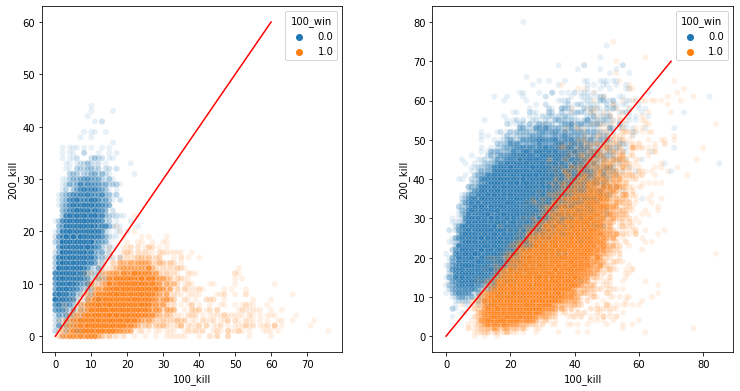

In [22]:
# 양편 kill 대비 승리여부

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = duration_df1, x='100_kill', y='200_kill', hue='100_win', alpha = 0.1)
plt.plot([0, 60], [0,60], 'r-')


plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_kill', y='200_kill', hue='100_win', alpha = 0.1)
plt.plot([0, 70], [0,70], 'r-')

* 경기 시간이 짧을 수록 양 팀의 수치 차이가 명확하게 나타나고, 경기 시간이 길어질 수록 차이가 줄어들어 변수의 영향력이 줄어듦을 확인할 수 있다.

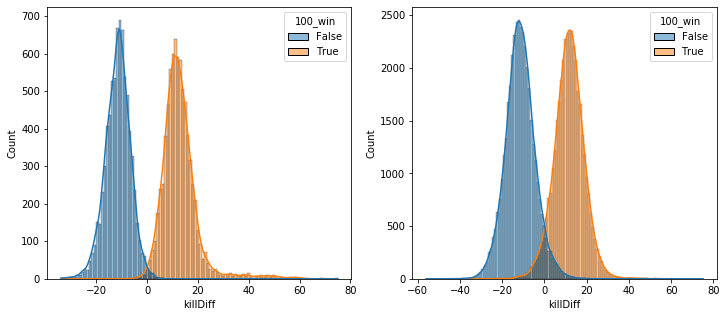

In [70]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = duration_df1, x='killDiff', hue= '100_win', kde = True, bins = 110)

plt.subplot(122)
_ = sns.histplot(data = duration_df2, x='killDiff', hue= '100_win', kde = True, bins = 130)

In [86]:
plt.figure(figsize = (12,5))

# plt.subplot(121)
# _ = sns.barplot(data = duration_df1, x='100_towerKills', y = "100_win")

# sns.factorplot(win_lose_df, "win", "firstBlood")


<Figure size 864x360 with 0 Axes>

#### Vision (시야 확보)

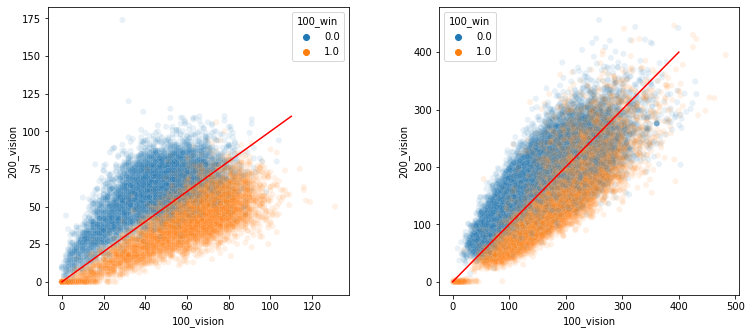

In [35]:
# 양편 시야 확보 대비 승리여부

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = duration_df1, x='100_vision', y='200_vision', hue='100_win', alpha = 0.1)
plt.plot([0, 110], [0,110], 'r-')


plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_vision', y='200_vision', hue='100_win', alpha = 0.1)
plt.plot([0, 400], [0,400], 'r-')

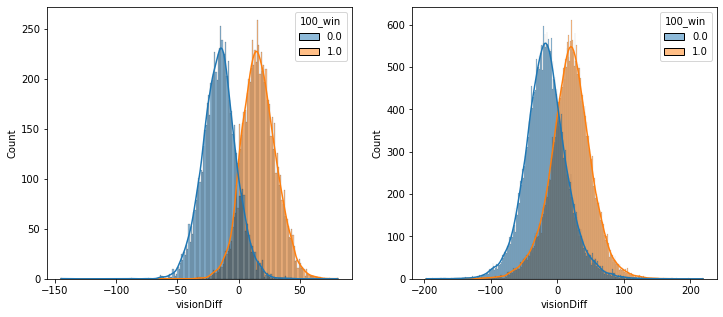

In [44]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = duration_df1, x='visionDiff', hue= '100_win', kde = True, binwidth=1)

plt.subplot(122)
_ = sns.histplot(data = duration_df2, x='visionDiff', hue= '100_win', kde = True, binwidth=1)

* Kill stat 과 마찬가지로 양편의 차이를 보여주고 있으나, 차이의 정도는 다소 떨어짐을 알 수 있다.

In [104]:
# _ = sns.scatterplot(data = sample_df, x='100_timeCC', y='200_timeCC', hue='100_win', alpha = 0.1)
# plt.plot([0, 400], [0,400], 'r-')

#### Gold 획득량

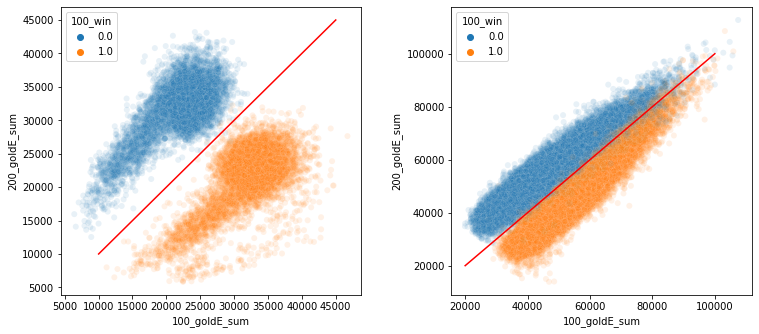

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = duration_df1, x='100_goldE_sum', y='200_goldE_sum', hue='100_win', alpha = 0.1)
plt.plot([10000, 45000], [10000,45000], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_goldE_sum', y='200_goldE_sum', hue='100_win', alpha = 0.1)
plt.plot([20000, 100000], [20000,100000], 'r-')

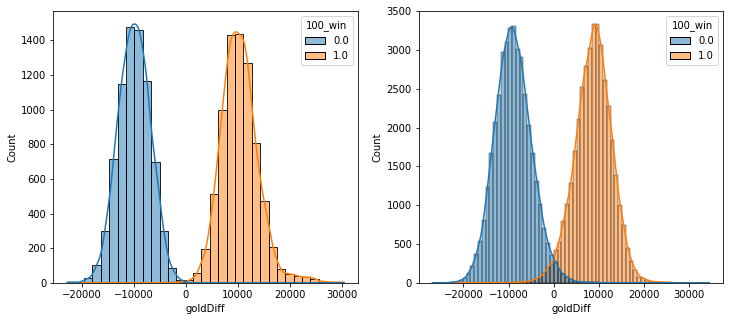

In [51]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = duration_df1, x='goldDiff', hue= '100_win', kde = True)

plt.subplot(122)
_ = sns.histplot(data = duration_df2, x='goldDiff', hue= '100_win', kde = True)

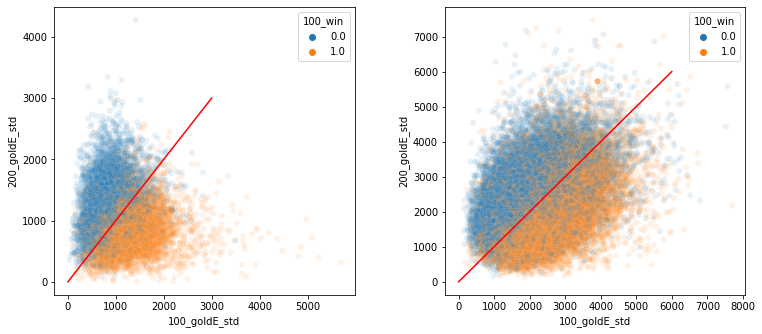

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = duration_df1, x='100_goldE_std', y='200_goldE_std', hue='100_win', alpha = 0.1)
plt.plot([0, 3000], [0,3000], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_goldE_std', y='200_goldE_std', hue='100_win', alpha = 0.1)
plt.plot([0, 6000], [0,6000], 'r-')

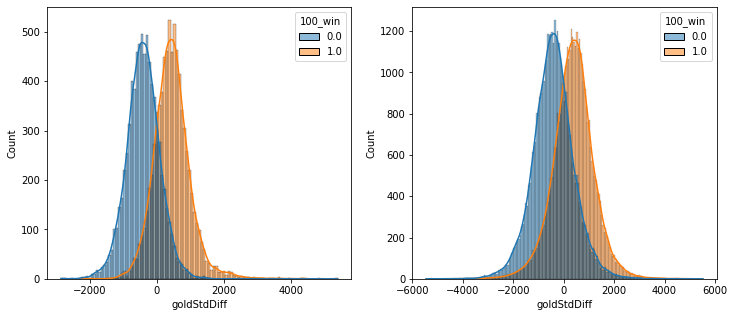

In [18]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = duration_df1, x='goldStdDiff', hue= '100_win', kde = True)

plt.subplot(122)
_ = sns.histplot(data = duration_df2, x='goldStdDiff', hue= '100_win', kde = True)

c:\programdata\anaconda3\envs\nano1\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


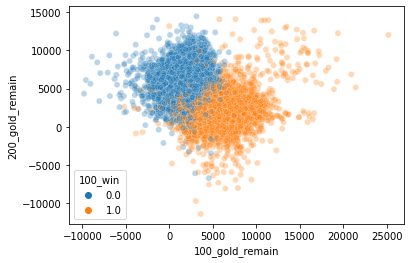

In [57]:
temp = duration_df1[['100_win', '100_goldE_sum', '100_goldS','200_goldE_sum', '200_goldS']]
temp['100_gold_remain'] = temp['100_goldE_sum'] - temp['100_goldS']
temp['200_gold_remain'] = temp['200_goldE_sum'] - temp['200_goldS']
_ = sns.scatterplot(data = temp, x='100_gold_remain', y='200_gold_remain', hue='100_win', alpha = 0.3)
# plt.plot([0, 6000], [0,6000], 'r-')

#### gold 사용량

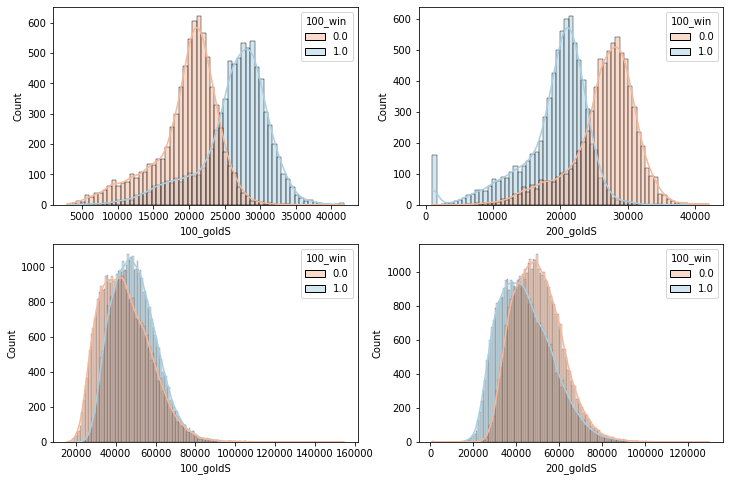

In [23]:
plt.figure(figsize = (12,8))

plt.subplot(221)
plt.subplots_adjust(hspace=0.2)
_ = sns.histplot(data= sample_df[sample_df['durationType']==1], x='100_goldS', hue='100_win', palette='RdBu', kde=True)

plt.subplot(222)
_ = sns.histplot(data= sample_df[sample_df['durationType']==1], x='200_goldS', hue='100_win', palette='RdBu', kde=True)

plt.subplot(223)
_ = sns.histplot(data= sample_df[sample_df['durationType']==2], x='100_goldS', hue='100_win', palette='RdBu', kde=True)

plt.subplot(224)
_ = sns.histplot(data= sample_df[sample_df['durationType']==2], x='200_goldS', hue='100_win', palette='RdBu', kde=True)

#### champ 레벨 비교

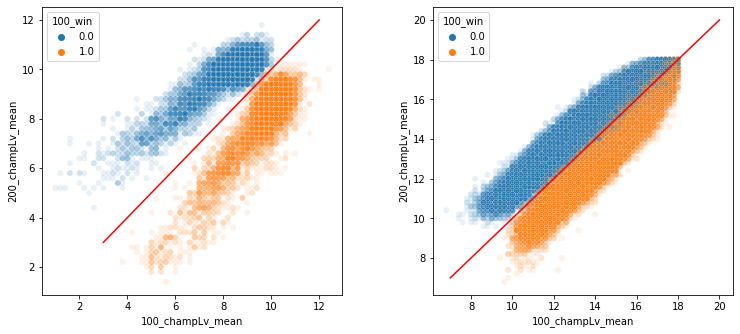

In [61]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = duration_df1, x='100_champLv_mean', y='200_champLv_mean', hue='100_win', alpha = 0.1)
plt.plot([3, 12], [3, 12], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_champLv_mean', y='200_champLv_mean', hue='100_win', alpha = 0.1)
plt.plot([7, 20], [7,20], 'r-')

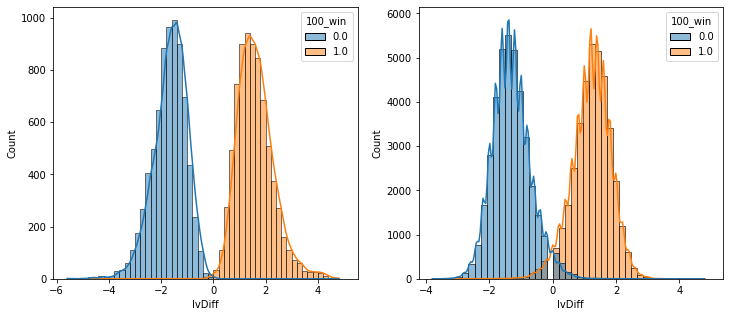

In [72]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = duration_df1, x='lvDiff', hue= '100_win', kde = True, binwidth = 0.2)

plt.subplot(122)
_ = sns.histplot(data = duration_df2, x='lvDiff', hue= '100_win', kde = True,  binwidth = 0.19)

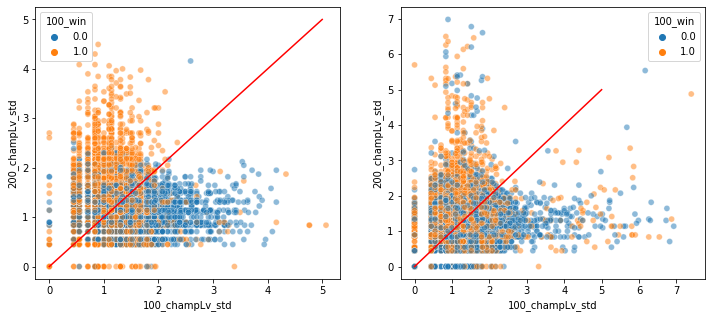

In [29]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.scatterplot(data = duration_df1, x='100_champLv_std', y='200_champLv_std', hue='100_win', alpha = 0.5)
plt.plot([0, 5], [0,5], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = duration_df2, x='100_champLv_std', y='200_champLv_std', hue='100_win', alpha = 0.5)
plt.plot([0, 5], [0,5], 'r-')



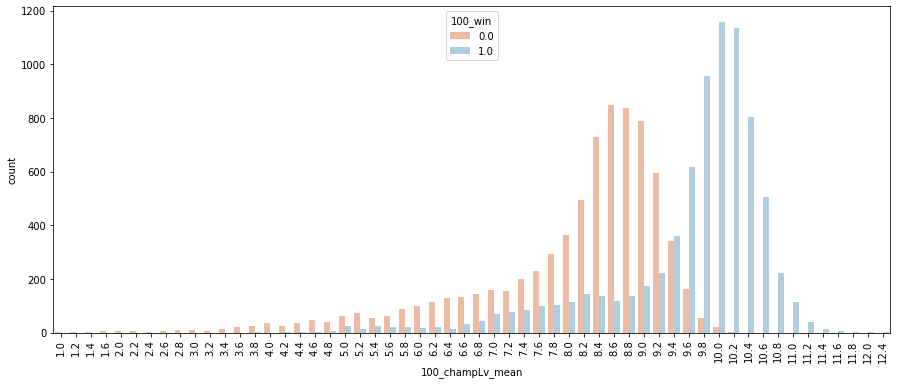

In [88]:
plt.figure(figsize = (15,6))
_ = sns.countplot(data= sample_df[sample_df['durationType'] == 1], x='100_champLv_mean', hue='100_win', palette='RdBu')
plt.xticks(rotation = 90)
plt.show()

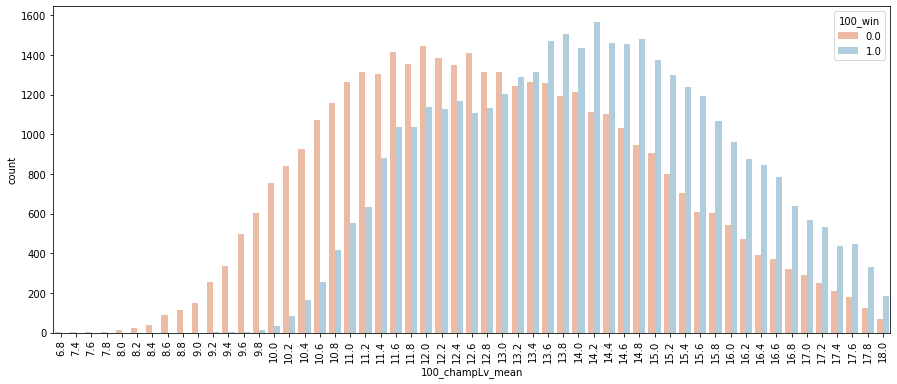

In [87]:
plt.figure(figsize = (15,6))
_ = sns.countplot(data= sample_df[sample_df['durationType'] == 2], x='100_champLv_mean', hue='100_win', palette='RdBu')
plt.xticks(rotation = 90)
plt.show()

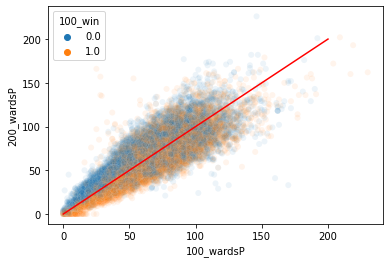

In [609]:
# _ = sns.scatterplot(data = sample_df, x='100_wardsP', y='200_wardsP', hue='100_win', alpha = 0.08)
# plt.plot([0, 200], [0,200], 'r-')

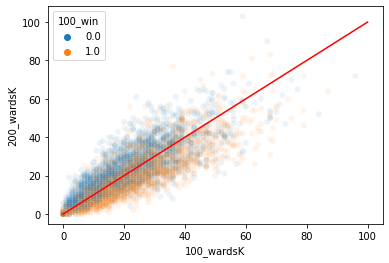

In [406]:
# _ = sns.scatterplot(data = sample_df, x='100_wardsK', y='200_wardsK', hue='100_win', alpha = 0.08)
# plt.plot([0, 100], [0,100], 'r-')

### 범주형 데이터 시각화

In [15]:
# from sklearn.preprocessing import LabelEncoder

# def sort_out(df_to_sort, sample_df):
#     tmp_df = df_to_sort.copy()
#     sample = sample_df.copy()
    
#     id_dur = sample.drop_duplicates().sort_values("gameId")[["gameDuration", "gameId"]].reset_index().copy()
#     game_id = id_dur["gameId"]
#     tmp_df = tmp_df.set_index("gameId").loc[game_id].copy()
#     tmp_df = tmp_df.reset_index()
#     tmp_df = tmp_df.drop_duplicates(['gameId'], keep='first').reset_index(drop = True)
#     tmp_df["gameDuration"] = id_dur["gameDuration"]
#     return tmp_df

# def durationType(x) :
#     if x <= 400 :
#         return "match"
#     elif x <= 1020 :
#         return 1
#     elif x<= 1800: 
#         return 2
#     else:
#         return 3

# winner = sort_out(winner_df, sample_df)
# loser = sort_out(loser_df, sample_df)
# loser.head()

<AxesSubplot:xlabel='win', ylabel='firstBlood'>

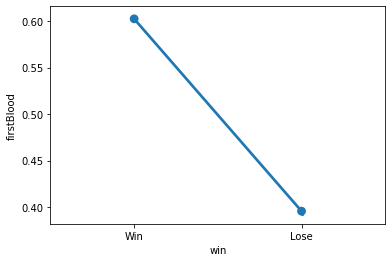

In [32]:
le = LabelEncoder()
# win_lose_df = pd.concat([winner,loser], axis = 0).drop(['dominionVictoryScore','vilemawKills','bans'], axis = 1).reset_index(drop = True)
bool_col = wl_df.select_dtypes(include = "bool").columns.to_list()

for col in bool_col:
    wl_df[col]=le.fit_transform(wl_df[col])
wl_df["win"] = wl_df["win"].replace({"Fail":"Lose"})

sns.pointplot(x ='win', y ='firstBlood', data = wl_df)  

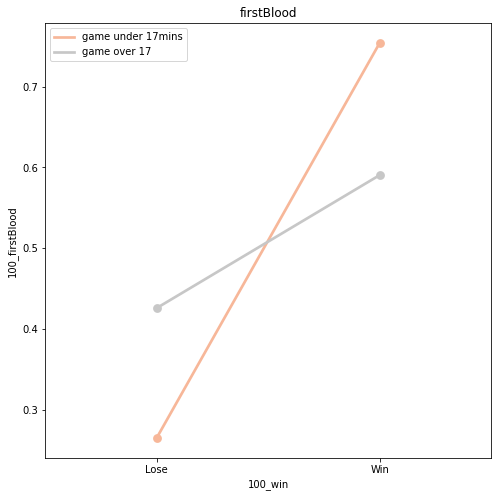

In [40]:
# win_lose_df['durationType']= win_lose_df['gameDuration'].apply(durationType)

# wl_duration1 = win_lose_df[win_lose_df["durationType"] == 1].copy()
# wl_duration2 = win_lose_df[win_lose_df["durationType"] == 2].copy()

plt.figure(figsize = (8,8))
sns.pointplot(x ='100_win', y ='100_firstBlood', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None , palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17", 
                   #"game over 30 mins"
                  ])
plt.title("firstBlood")
plt.show()


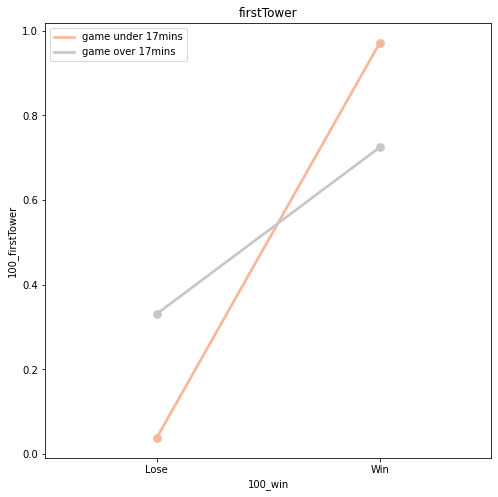

In [43]:
# firstTower	firstInhibitor	firstBaron	firstDragon	firstRiftHerald
plt.figure(figsize = (8,8))
sns.pointplot(x ='100_win', y ='100_firstTower', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None, palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17mins"])
plt.title("firstTower")
plt.show()

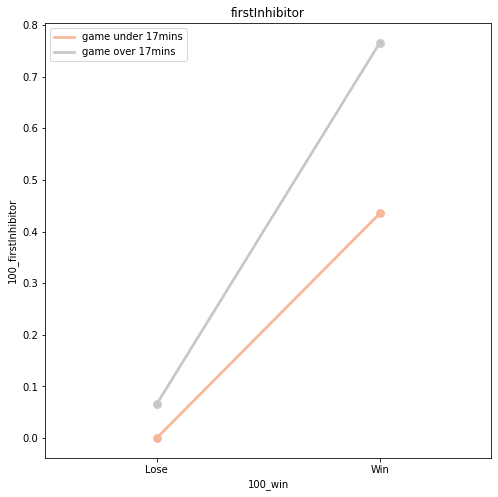

In [44]:
# firstTower	firstInhibitor	firstBaron	firstDragon	firstRiftHerald
plt.figure(figsize = (8,8))
sns.pointplot(x ='100_win', y ='100_firstInhibitor', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None, palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17mins"])

plt.title("firstInhibitor")
plt.show()

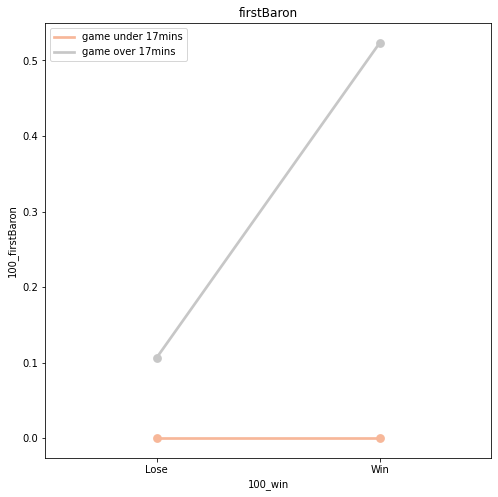

In [50]:
# firstTower	firstInhibitor	firstBaron	firstDragon	firstRiftHerald
plt.figure(figsize = (8,8))

sns.pointplot(x ='100_win', y ='100_firstBaron', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None, palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17mins"])

plt.title("firstBaron")
plt.show()

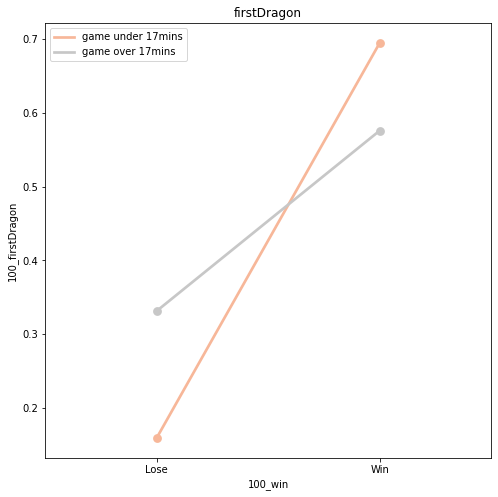

In [51]:
plt.figure(figsize = (8,8))

sns.pointplot(x ='100_win', y ='100_firstDragon', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None, palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17mins"])

plt.title("firstDragon")
plt.show()

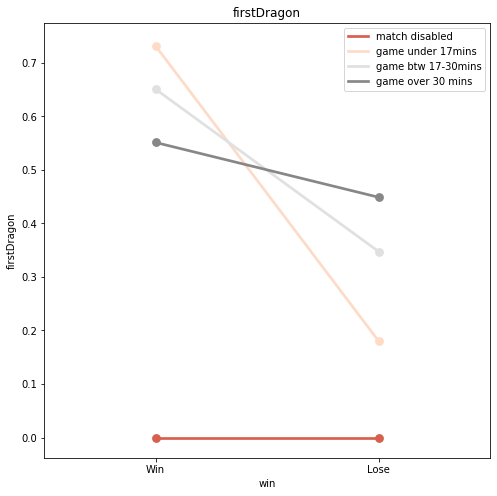

In [395]:
plt.figure(figsize = (8,8))
sns.pointplot(x ='win', y ='firstDragon', data = win_lose_df, hue= "durationType", ci = None, palette="RdGy")
plt.legend(labels=["match disabled","game under 17mins", "game btw 17-30mins", "game over 30 mins"])
plt.title("firstDragon")
plt.show()

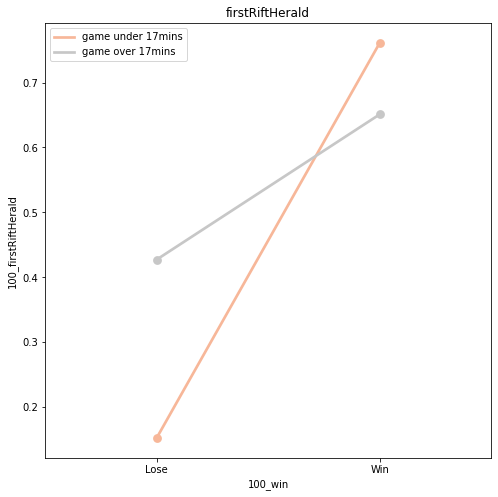

In [53]:
plt.figure(figsize = (8,8))

sns.pointplot(x ='100_win', y ='100_firstRiftHerald', data = sample_df[sample_df['durationType'] > 0], hue= "durationType", ci = None, palette="RdGy")
plt.xticks(ticks=[0,1], labels = ['Lose', 'Win'])
plt.legend(labels=["game under 17mins", "game over 17mins"])

plt.title("firstRiftHerald")
plt.show()

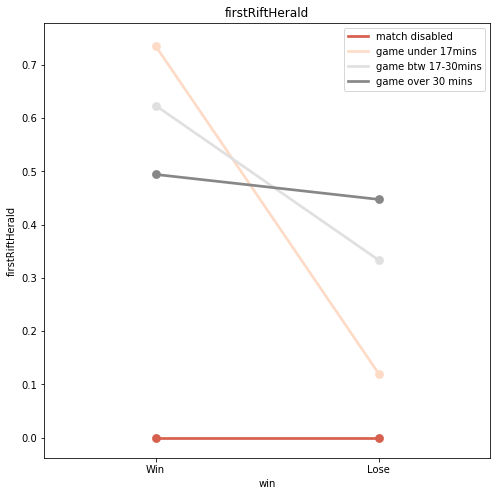

In [396]:
plt.figure(figsize = (8,8))
sns.pointplot(x ='win', y ='firstRiftHerald', data = win_lose_df, hue= "durationType", ci = None, palette="RdGy")
plt.legend(labels=["match disabled","game under 17mins", "game btw 17-30mins", "game over 30 mins"])
plt.title("firstRiftHerald")
plt.show()

In [427]:
sample_df.columns

Index(['gameDuration', 'gameId', '100_win', '100_kill', '100_vision',
       '100_timeCC', '100_tTimeCC', '100_goldE_std', '100_goldE_sum',
       '100_goldS', '100_minionK', '100_nMinionK', '100_champLv_mean',
       '100_champLv_std', '100_wardsP', '100_wardsK', '200_win', '200_kill',
       '200_vision', '200_timeCC', '200_tTimeCC', '200_goldE_std',
       '200_goldE_sum', '200_goldS', '200_minionK', '200_nMinionK',
       '200_champLv_mean', '200_champLv_std', '200_wardsP', '200_wardsK',
       '100_firstBlood', '100_firstTower', '100_firstInhibitor',
       '100_firstBaron', '100_firstDragon', '100_firstRiftHerald',
       '100_towerKills', '100_inhibitorKills', '100_baronKills',
       '100_dragonKills', '100_vilemawKills', '100_riftHeraldKills',
       '200_firstBlood', '200_firstTower', '200_firstInhibitor',
       '200_firstBaron', '200_firstDragon', '200_firstRiftHerald',
       '200_towerKills', '200_inhibitorKills', '200_baronKills',
       '200_dragonKills', '200_vilemawKi

<AxesSubplot:xlabel='100_baronKills', ylabel='count'>

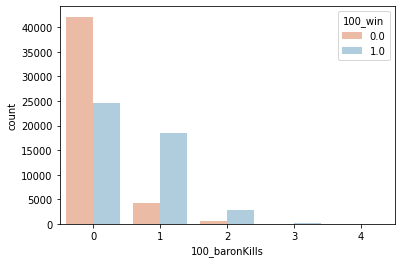

In [76]:
plt.figure(figsize = (12,8))

plt.subplot(221)
plt.subplots_adjust(hspace=0.2)
_ = sns.countplot(data= duration_df1, x='100_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(222)
_ = sns.countplot(data= duration_df1, x='200_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(223)
_ = sns.countplot(data= duration_df2, x='100_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(224)
_ = sns.countplot(data= duration_df2, x='200_dragonKills', hue='100_win', palette='RdBu')

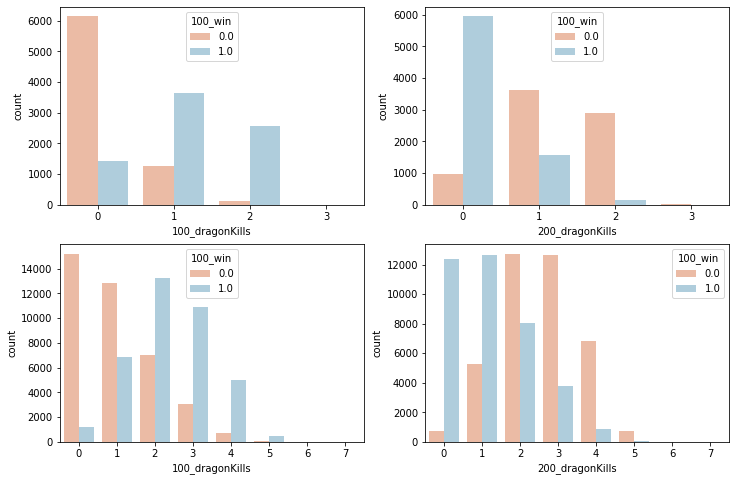

In [30]:
plt.figure(figsize = (12,8))

plt.subplot(221)
plt.subplots_adjust(hspace=0.2)
_ = sns.countplot(data= duration_df1, x='100_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(222)
_ = sns.countplot(data= duration_df1, x='200_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(223)
_ = sns.countplot(data= duration_df2, x='100_dragonKills', hue='100_win', palette='RdBu')

plt.subplot(224)
_ = sns.countplot(data= duration_df2, x='200_dragonKills', hue='100_win', palette='RdBu')



<AxesSubplot:xlabel='100_riftHeraldKills', ylabel='count'>

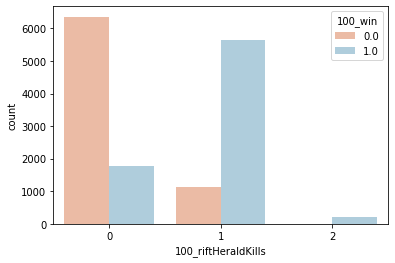

In [80]:
sns.countplot(data= sample_df[sample_df['durationType'] == 1], x='100_riftHeraldKills', hue='100_win', palette='RdBu')

<AxesSubplot:xlabel='100_riftHeraldKills', ylabel='count'>

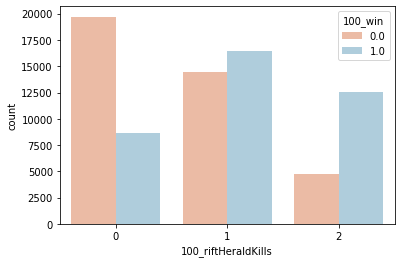

In [81]:
sns.countplot(data= sample_df[sample_df['durationType'] == 2], x='100_riftHeraldKills', hue='100_win', palette='RdBu')

### 상관도 분석

In [19]:
duration_df1.columns

Index(['100_win', '100_kill', '100_vision', '100_goldE_std', '100_goldE_sum',
       '100_goldS', '100_champLv_mean', '100_champLv_std', '200_kill',
       '200_vision', '200_goldE_std', '200_goldE_sum', '200_goldS',
       '200_champLv_mean', '200_champLv_std', '100_firstBlood',
       '100_firstTower', '100_firstInhibitor', '100_firstBaron',
       '100_firstDragon', '100_firstRiftHerald', '100_towerKills',
       '100_inhibitorKills', '100_baronKills', '100_dragonKills',
       '100_riftHeraldKills', '200_firstBlood', '200_firstTower',
       '200_firstInhibitor', '200_firstBaron', '200_firstDragon',
       '200_firstRiftHerald', '200_towerKills', '200_inhibitorKills',
       '200_baronKills', '200_dragonKills', '200_riftHeraldKills',
       'durationType', 'killDiff', 'visionDiff', 'goldDiff', 'goldStdDiff',
       'spandDiff', 'lvDiff', 'lvStdDiff', 'killTowerDiff',
       'killInhibitorDiff', 'killBaronDiff', 'killDragonDiff',
       'killRiftHeraldDiff'],
      dtype='object')

In [20]:
corr_cols = [
            '100_win',
            'killDiff', 'visionDiff', 'goldDiff', 'spandDiff','lvDiff',
            '100_champLv_std','200_champLv_std',
            '100_firstBlood', '100_firstTower', '100_firstInhibitor',
            '100_firstDragon', '100_firstRiftHerald', '100_towerKills',
            '100_inhibitorKills', '100_dragonKills',
            '100_riftHeraldKills', '200_firstBlood', '200_firstTower',
            '200_firstInhibitor', '200_firstDragon',
            '200_firstRiftHerald', '200_towerKills', '200_inhibitorKills',
            '200_dragonKills', '200_riftHeraldKills'
            ]

corr_cols2 = [
            '100_win',
            'killDiff', 'visionDiff', 'goldDiff', 'goldStdDiff',
            'spandDiff', 'lvDiff', 'lvStdDiff', 'killTowerDiff',
            'killInhibitorDiff', 'killBaronDiff', 'killDragonDiff',
            'killRiftHeraldDiff',
            '100_firstBlood','100_firstTower', '100_firstInhibitor', 
            '100_firstBaron','100_firstDragon', '100_firstRiftHerald'
            ]

In [21]:
corr_type1 = duration_df1[corr_cols2].corr()
corr_type2 = duration_df2[corr_cols2].corr()

#### durationType 1 상관도 분석

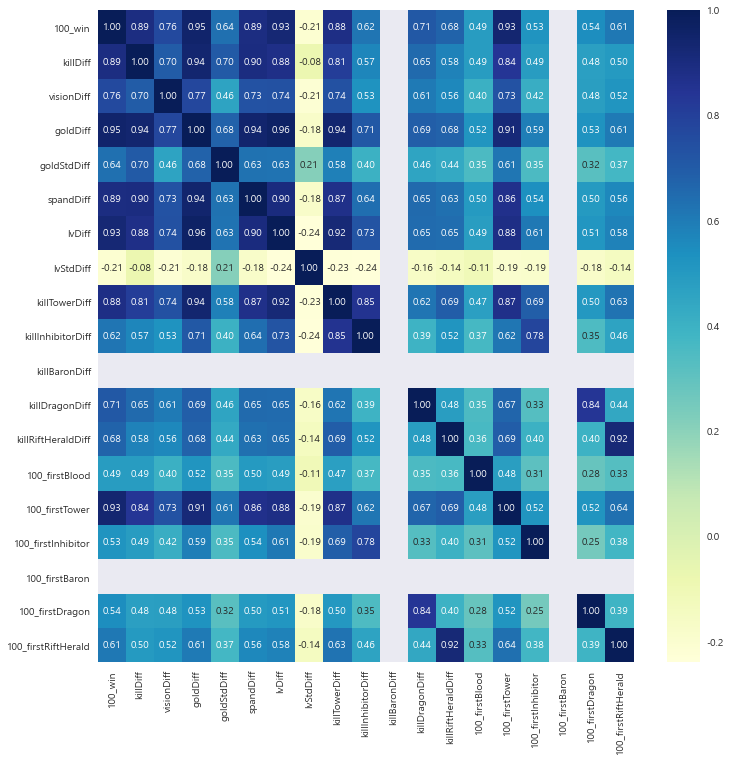

In [48]:
plt.figure(figsize=(12,12))
_ = sns.heatmap(corr_type1, annot = True, fmt = '.2f', cmap='YlGnBu')

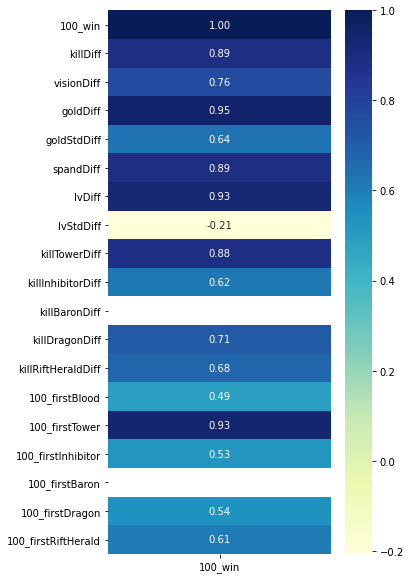

In [43]:
plt.figure(figsize=(5,10))
_ = sns.heatmap(corr_type1[['100_win']], annot = True, fmt = '.2f', cmap='YlGnBu')

#### durationType 2 상관도 분석

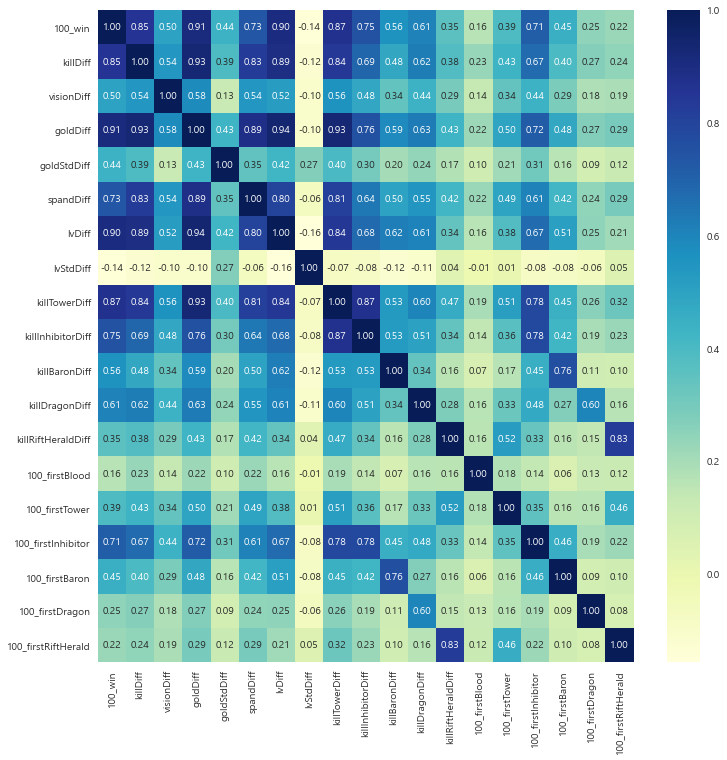

In [49]:
plt.figure(figsize=(12,12))
_ = sns.heatmap(corr_type2, annot = True, fmt = '.2f', cmap='YlGnBu')

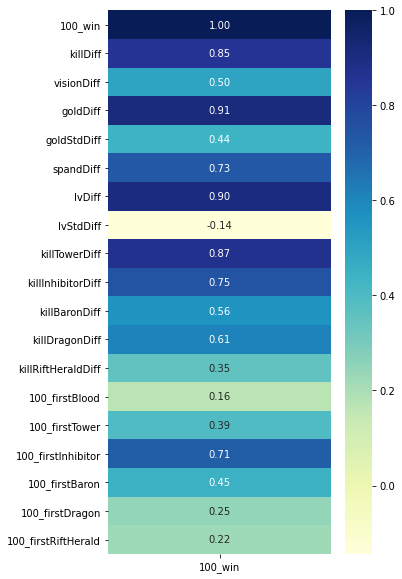

In [28]:
plt.figure(figsize=(5,10))
_ = sns.heatmap(corr_type2[['100_win']], annot = True, fmt = '.2f', cmap='YlGnBu')

#### durationType 간 상관도 비교

Text(0.5, 1.0, 'DurationType2 100_Win Corr')

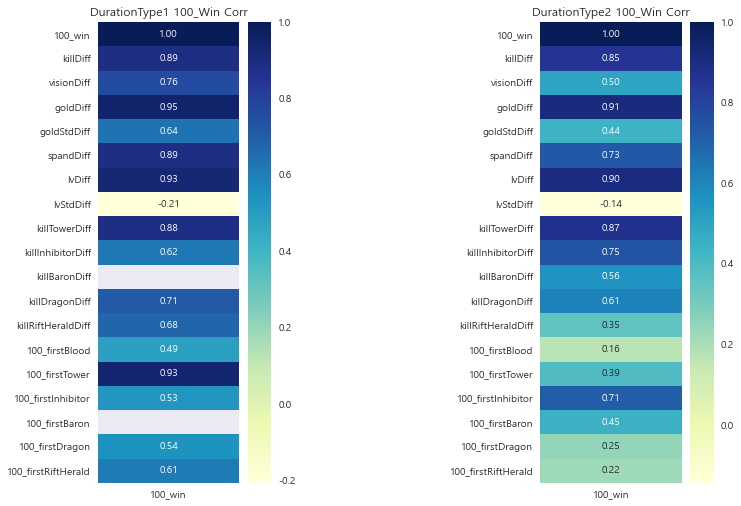

In [50]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.2, top=0.9, wspace=1.5, hspace=0.2)
_ = sns.heatmap(corr_type1[['100_win']], annot = True, fmt = '.2f', cmap='YlGnBu')
plt.title('DurationType1 100_Win Corr')


plt.subplot(122)
_ = sns.heatmap(corr_type2[['100_win']], annot = True, fmt = '.2f', cmap='YlGnBu')
plt.title('DurationType2 100_Win Corr')

In [51]:
sample_df.head()

100_win  100_kill  100_vision  100_goldE_std  100_goldE_sum  100_goldS  \
0      0.0        15          91    1420.632148          37001      35847   
1      1.0        19         125    1468.909562          41072      34960   
2      0.0         5          52    1066.302818          22929      21985   
3      0.0        26         249    2593.168969          63447      61925   
4      1.0        27         278    2974.513490          74955      71580   

   100_champLv_mean  100_champLv_std  200_kill  200_vision  ...  \
0              11.2         1.303840        31         120  ...   
1              12.6         1.140175         8         111  ...   
2               8.4         1.140175        20          74  ...   
3              16.0         1.224745        36         243  ...   
4              16.6         1.673320        40         237  ...   

   200_inhibitorKills  200_baronKills  200_dragonKills  200_riftHeraldKills  \
0                   1               0                3                    2   
1                   0               0                0                    0   
2                   1               0                2                    2   
3                   0               1                3                    1   
4                   1               1                3                    0   

   durationType  killDiff  visionDiff  goldDiff  spandDiff  lvDiff  
0             2       -16         -29    -12831      -6088    -1.6  
1             2        11          14      3936       1360     0.8  
2             1       -15         -22    -12435      -8770    -1.6  
3             2       -10           6     -7081      -1968    -0.8  
4             2       -13          41       359      -2330    -0.4  

[5 rows x 43 columns]

In [30]:
duration_df1.columns

Index(['100_win', '100_kill', '100_vision', '100_goldE_std', '100_goldE_sum',
       '100_goldS', '100_champLv_mean', '100_champLv_std', '200_kill',
       '200_vision', '200_goldE_std', '200_goldE_sum', '200_goldS',
       '200_champLv_mean', '200_champLv_std', '100_firstBlood',
       '100_firstTower', '100_firstInhibitor', '100_firstBaron',
       '100_firstDragon', '100_firstRiftHerald', '100_towerKills',
       '100_inhibitorKills', '100_baronKills', '100_dragonKills',
       '100_riftHeraldKills', '200_firstBlood', '200_firstTower',
       '200_firstInhibitor', '200_firstBaron', '200_firstDragon',
       '200_firstRiftHerald', '200_towerKills', '200_inhibitorKills',
       '200_baronKills', '200_dragonKills', '200_riftHeraldKills',
       'durationType', 'killDiff', 'visionDiff', 'goldDiff', 'goldStdDiff',
       'spandDiff', 'lvDiff', 'lvStdDiff', 'killTowerDiff',
       'killInhibitorDiff', 'killBaronDiff', 'killDragonDiff',
       'killRiftHeraldDiff'],
      dtype='object')

In [31]:
num_col = [
       'killDiff', 'visionDiff',
       'goldDiff', 'spandDiff','goldStdDiff',
       'lvDiff', 'lvStdDiff',
       'killTowerDiff',
       'killInhibitorDiff', 'killBaronDiff', 'killDragonDiff',
       'killRiftHeraldDiff'
        ]

cate_col = ['100_firstBlood', '100_firstTower', '100_firstInhibitor',
           '100_firstBaron', '100_firstDragon', '100_firstRiftHerald']

target_col = ['100_win']

## 승패 예측 모델링

### light Gradient Boosting Model

In [33]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

In [34]:
duration_df1[num_col]

killDiff  visionDiff  goldDiff  spandDiff  goldStdDiff  lvDiff  \
0           -15         -22    -12435      -8770       -98.25   -1.60   
1            23          28     15101      11385       734.16    2.40   
2             9           7      7896       7160       641.66    1.40   
3           -13         -14     -9953      -9225       255.24   -1.20   
4           -11          -9     -5935      -2950       -45.80   -0.80   
...         ...         ...       ...        ...          ...     ...   
15141       -11          -9    -14528      -6125        52.52   -3.40   
15142        16          10      7425       5779       543.01    1.00   
15143       -10         -15    -10724       3957      -375.96   -1.60   
15144       -11           1     -7775      -2696      -188.93   -1.20   
15145        11          36     11788       8240       -18.35    1.80   

       lvStdDiff  killTowerDiff  killInhibitorDiff  killBaronDiff  \
0           0.14             -5                 -1              0   
1          -0.20              5                  0              0   
2           0.09              3                  0              0   
3           0.60             -4                  0              0   
4          -0.28             -1                  0              0   
...          ...            ...                ...            ...   
15141       1.30             -8                 -1              0   
15142       0.00              3                  0              0   
15143      -0.87             -7                 -1              0   
15144       0.04             -2                  0              0   
15145      -0.78              5                  1              0   

       killDragonDiff  killRiftHeraldDiff  
0                  -2                  -2  
1                   2                   1  
2                   2                  -1  
3                   0                  -1  
4                   0                  -1  
...               ...                 ...  
15141               0                  -1  
15142               2                   1  
15143              -2                   1  
15144              -1                  -1  
15145               1                   1  

[15146 rows x 12 columns]

In [35]:
scaler = StandardScaler()

x_num = duration_df1[num_col]
scaler.fit(x_num)
x_scaled = scaler.transform(x_num)

x_scaled = pd.DataFrame(x_scaled, index=x_num.index, columns = x_num.columns)

x_cat = duration_df1[cate_col].reset_index(drop = True)

X1 = pd.concat([x_scaled,x_cat], axis = 1)
y1 = duration_df1['100_win']

In [36]:
x_scaled

killDiff  visionDiff  goldDiff  spandDiff  goldStdDiff  lvDiff  \
0         -1.14       -1.05     -1.19      -1.14        -0.18   -0.91   
1          1.61        1.28      1.39       1.40         1.05    1.35   
2          0.60        0.30      0.71       0.87         0.92    0.78   
3         -0.99       -0.68     -0.96      -1.19         0.34   -0.69   
4         -0.85       -0.45     -0.58      -0.40        -0.10   -0.46   
...         ...         ...       ...        ...          ...     ...   
15141     -0.85       -0.45     -1.39      -0.80         0.04   -1.93   
15142      1.11        0.44      0.67       0.69         0.77    0.56   
15143     -0.78       -0.73     -1.03       0.46        -0.59   -0.91   
15144     -0.85        0.02     -0.76      -0.37        -0.31   -0.69   
15145      0.75        1.65      1.08       1.00        -0.06    1.01   

       lvStdDiff  killTowerDiff  killInhibitorDiff  killBaronDiff  \
0           0.18          -1.01              -1.40           0.00   
1          -0.33           0.95              -0.04           0.00   
2           0.11           0.56              -0.04           0.00   
3           0.88          -0.82              -0.04           0.00   
4          -0.45          -0.23              -0.04           0.00   
...          ...            ...                ...            ...   
15141       1.94          -1.60              -1.40           0.00   
15142      -0.03           0.56              -0.04           0.00   
15143      -1.34          -1.41              -1.40           0.00   
15144       0.03          -0.42              -0.04           0.00   
15145      -1.21           0.95               1.32           0.00   

       killDragonDiff  killRiftHeraldDiff  
0               -1.40               -2.15  
1                1.49                0.97  
2                1.49               -1.11  
3                0.05               -1.11  
4                0.05               -1.11  
...               ...                 ...  
15141            0.05               -1.11  
15142            1.49                0.97  
15143           -1.40                0.97  
15144           -0.68               -1.11  
15145            0.77                0.97  

[15146 rows x 12 columns]

In [37]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=910)

In [38]:
scaler = StandardScaler()

x_num = duration_df2[num_col]
scaler.fit(x_num)
x_scaled = scaler.transform(x_num)

x_scaled = pd.DataFrame(x_scaled, index=x_num.index, columns = x_num.columns)

x_cat = duration_df2[cate_col].reset_index(drop = True)

X2 = pd.concat([x_scaled,x_cat], axis = 1)
y2 = duration_df2['100_win']

In [39]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=910)

In [40]:
lgbm = LGBMClassifier()

parameters = {
            'max_depth' : [3],
            'num_leaves' : [32,64,128],
            'min_data_in_leaf' : [1,5,10],
            'colsample_bytree' : [0.8, 1],
            'n_estimators' : [100,150]}

GS_light = GridSearchCV(lgbm, parameters, cv = 10, scoring = 'accuracy')
GS_light.fit(X1_train, y1_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1], 'max_depth': [3],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 150],
                         'num_leaves': [32, 64, 128]},
             scoring='accuracy')

In [51]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GS_light.cv_results_['mean_test_score']
stds = GS_light.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_light.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 32}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 64}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 128}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 32}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 64}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 128}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 32}
0.999 (+/-0.001) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 64

#### lightGBM durationType 1 모델링 결과

In [52]:
print(GS_light.best_params_)
print(GS_light.best_score_)

{'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 150, 'num_leaves': 32}
0.9994340511799121


* DurationType 1 (under 1020) 정확도 확인

In [53]:
pred = GS_light.predict(X1_test)

print(classification_report(y1_test, pred))
print(confusion_matrix(y1_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2248
         1.0       1.00      1.00      1.00      2296

    accuracy                           1.00      4544
   macro avg       1.00      1.00      1.00      4544
weighted avg       1.00      1.00      1.00      4544

[[2247    1]
 [   1 2295]]


In [61]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[2247,1],[1,2295]])

Predicted      
                  Win  Lose
Actual Win       2247     1
       Lose         1  2295

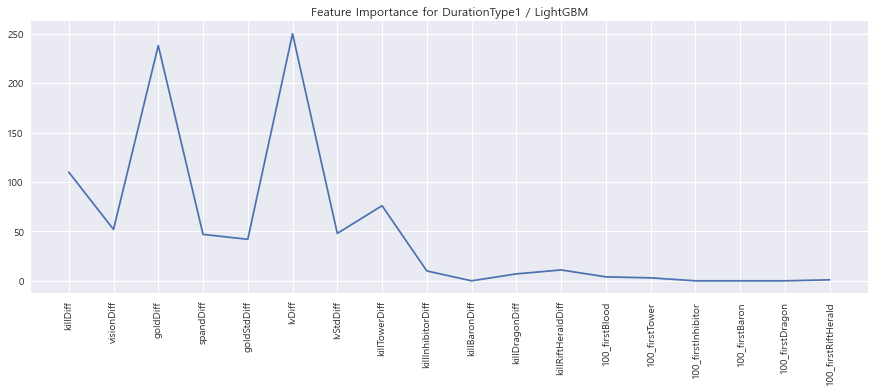

In [62]:
plt.figure(figsize = (15,5))
plt.plot(X1.columns, GS_light.best_estimator_.feature_importances_)

plt.title('Feature Importance for DurationType1 / LightGBM')
plt.xticks(rotation = 90)
plt.show()

In [55]:
lgbm = LGBMClassifier()

parameters = {
            'max_depth' : [3],
            'num_leaves' : [32,64,128],
            'min_data_in_leaf' : [1,5,10],
            'colsample_bytree' : [0.8, 1],
            'n_estimators' : [100,150]}

GS_light2 = GridSearchCV(lgbm, parameters, cv = 10, scoring = 'accuracy')
GS_light2.fit(X2_train, y2_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1], 'max_depth': [3],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 150],
                         'num_leaves': [32, 64, 128]},
             scoring='accuracy')

#### lightGBM durationType 2 모델링 결과

In [56]:
pred = GS_light2.predict(X2_test)

print(classification_report(y2_test, pred))
print(confusion_matrix(y2_test, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     11653
         1.0       0.99      0.99      0.99     11353

    accuracy                           0.99     23006
   macro avg       0.99      0.99      0.99     23006
weighted avg       0.99      0.99      0.99     23006

[[11591    62]
 [   62 11291]]


In [63]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[11591,62],[62,11291]])

Predicted       
                  Win   Lose
Actual Win      11591     62
       Lose        62  11291

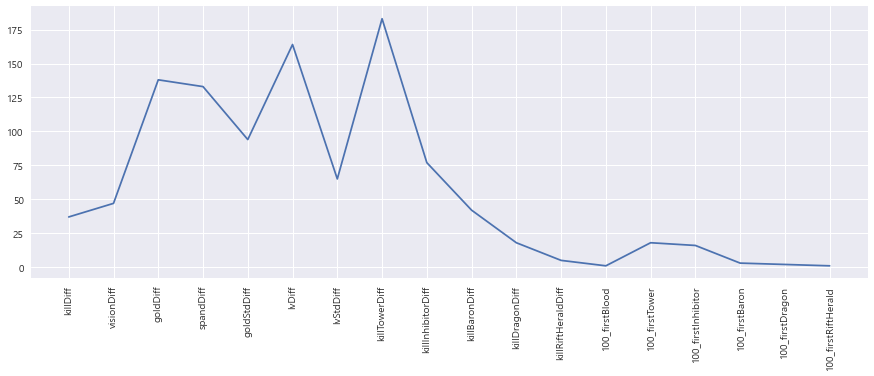

In [57]:
plt.figure(figsize = (15,5))
plt.plot(X2.columns, GS_light2.best_estimator_.feature_importances_)

plt.xticks(rotation = 90)
plt.show()

#### feature importance 분석

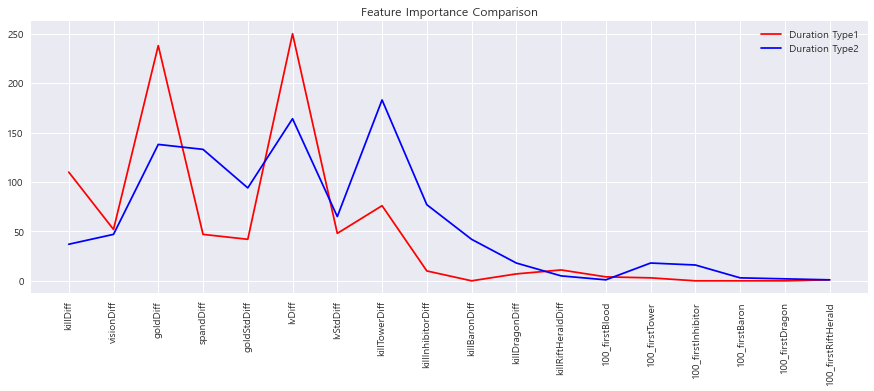

In [77]:
plt.figure(figsize = (15,5))

plt.plot(X1.columns, GS_light.best_estimator_.feature_importances_, 'r-', label='Duration Type1')
plt.plot(X2.columns, GS_light2.best_estimator_.feature_importances_, 'b-', label='Duration Type2')
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Comparison')
plt.legend()
plt.show()

In [67]:
light_fi = pd.DataFrame(GS_light.best_estimator_.feature_importances_, index= X1.columns)
light_fi[0] = light_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

light2_fi = pd.DataFrame(GS_light2.best_estimator_.feature_importances_, index= X2.columns)
light2_fi[0] = light2_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

* 두 그룹의 모델링을 각기하여 정규화 시킨 feature importance 비교

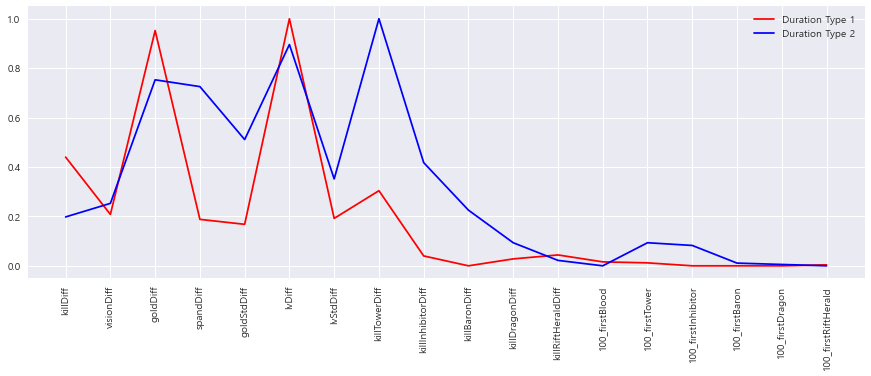

In [69]:
plt.figure(figsize = (15,5))

plt.plot(light_fi.index, light_fi[0], 'r-', label='Duration Type1')
plt.plot(light2_fi.index, light2_fi[0], 'b-', label = 'Duration Type 2')
plt.xticks(rotation = 90)
# plt.grid()
plt.legend()
plt.show()

## feature_importances 는 상대지표가 아닌가?

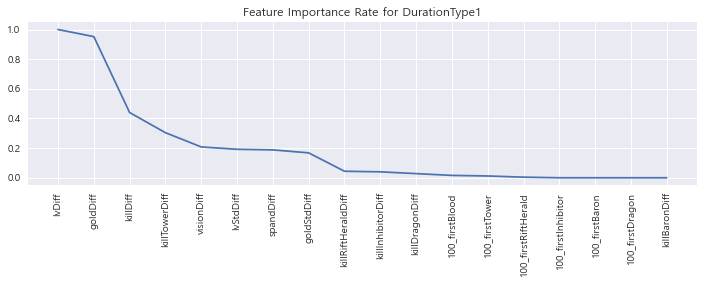

In [73]:
# durationType 2 (over 1020) 의 피쳐중요도 순 나열
plt.figure(figsize = (12, 3))
plt.plot(light_fi[0].sort_values(ascending=False).index, light_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
plt.title('Feature Importance Rate for DurationType1')
# plt.grid()
plt.show()

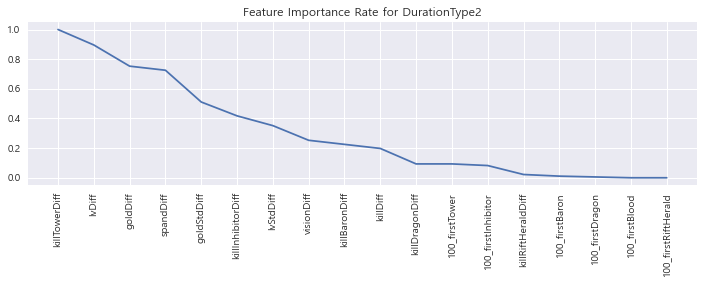

In [74]:
# durationType 2 (over 1020) 의 피쳐중요도 순 나열
plt.figure(figsize = (12, 3))
plt.plot(light2_fi[0].sort_values(ascending=False).index, light2_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
plt.title('Feature Importance Rate for DurationType2')
# plt.grid()
plt.show()

#### ROC 그래프

In [78]:
from sklearn.metrics import plot_roc_curve

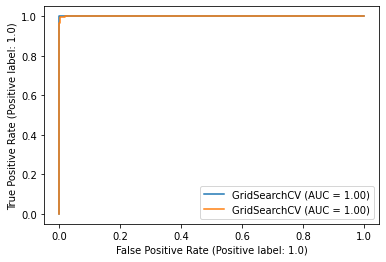

In [79]:
fig = plt.figure()
ax = fig.gca()
plot_roc_curve(GS_light, X1_test, y1_test, ax= ax)
plot_roc_curve(GS_light2, X2_test, y2_test, ax= ax)

### Linear Regression


In [78]:
lg = LogisticRegression()
parameters_lg = {
    'penalty' : ['l1','l2'],
    'solver' : ['lbfgs', 'liblinear'],
    'tol': [0.01, 0.1 , 1],
}

GS_lg = GridSearchCV(lg, parameters_lg, cv = 10, scoring = 'accuracy')
GS_lg.fit(X1_train, y1_train)

c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\programdata\anaconda3\

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [0.01, 0.1, 1]},
             scoring='accuracy')

In [79]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GS_lg.cv_results_['mean_test_score']
stds = GS_lg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_lg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.01}
nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.1}
nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 1}
0.999 (+/-0.001) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
0.997 (+/-0.005) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1}
0.974 (+/-0.061) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 1}
1.000 (+/-0.001) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
1.000 (+/-0.001) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1}
1.000 (+/-0.001) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1}
0.999 (+/-0.001) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}
0.998 (+/-0.002) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}
0.996 (+/-0.004) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 1}



#### linearRegression durationType 1 모델링 결과

In [80]:
pred = GS_lg.predict(X1_test)

print(classification_report(y1_test, pred))
print(confusion_matrix(y1_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2248
         1.0       1.00      1.00      1.00      2296

    accuracy                           1.00      4544
   macro avg       1.00      1.00      1.00      4544
weighted avg       1.00      1.00      1.00      4544

[[2247    1]
 [   1 2295]]


In [81]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[2247,1],[1,2295]])

Predicted      
                  Win  Lose
Actual Win       2247     1
       Lose         1  2295

In [82]:
lg = LogisticRegression()
parameters_lg = {
    'penalty' : ['l1','l2'],
    'solver' : ['lbfgs', 'liblinear'],
    'tol': [0.01, 0.1 , 1],
}

GS_lg2 = GridSearchCV(lg, parameters_lg, cv = 10, scoring = 'accuracy')
GS_lg2.fit(X2_train, y2_train)

c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\programdata\anaconda3\envs\nano1\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\programdata\anaconda3\

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [0.01, 0.1, 1]},
             scoring='accuracy')

In [83]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GS_lg2.cv_results_['mean_test_score']
stds = GS_lg2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_lg2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.01}
nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.1}
nan (+/-nan) for {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 1}
0.994 (+/-0.002) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
0.988 (+/-0.008) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1}
0.953 (+/-0.060) for {'penalty': 'l1', 'solver': 'liblinear', 'tol': 1}
0.995 (+/-0.002) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
0.995 (+/-0.002) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1}
0.995 (+/-0.002) for {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1}
0.995 (+/-0.002) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}
0.991 (+/-0.003) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.1}
0.971 (+/-0.005) for {'penalty': 'l2', 'solver': 'liblinear', 'tol': 1}



#### linearRegression durationType 2 모델링 결과

In [84]:
pred = GS_lg2.predict(X2_test)

print(classification_report(y2_test, pred))
print(confusion_matrix(y2_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     11653
         1.0       0.99      0.99      0.99     11353

    accuracy                           0.99     23006
   macro avg       0.99      0.99      0.99     23006
weighted avg       0.99      0.99      0.99     23006

[[11589    64]
 [   57 11296]]


In [85]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[11589,64],[57,11296]])

Predicted       
                  Win   Lose
Actual Win      11589     64
       Lose        57  11296

#### feature importance 분석

In [94]:
lg_fi = pd.DataFrame(GS_lg.best_estimator_.coef_, columns= X1.columns).transpose()
# lg_fi[0] = light_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

lg2_fi = pd.DataFrame(GS_lg2.best_estimator_.coef_, columns= X2.columns).transpose()
# lg2_fi[0] = light2_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

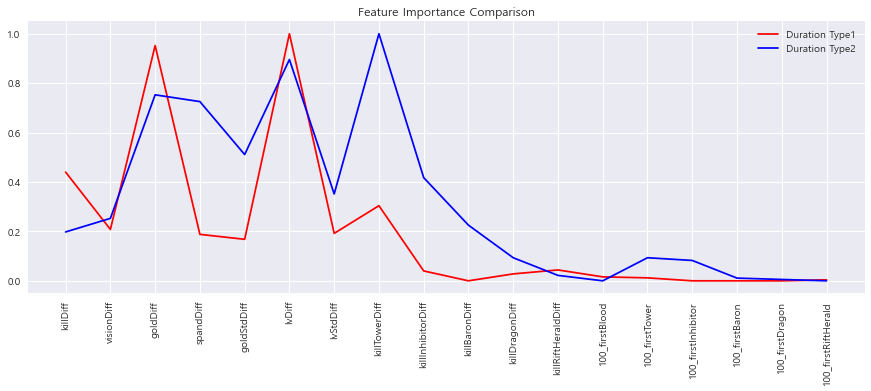

In [96]:
plt.figure(figsize = (15,5))

plt.plot(lg_fi.index, lg_fi[0], 'r-', label='Duration Type1')
plt.plot(lg2_fi.index, lg2_fi[0], 'b-', label='Duration Type2')
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Comparison')
plt.legend()
plt.show()

In [87]:
lg_fi = pd.DataFrame(GS_lg.best_estimator_.coef_, columns= X1.columns).transpose()
lg_fi[0] = light_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

lg2_fi = pd.DataFrame(GS_lg2.best_estimator_.coef_, columns= X2.columns).transpose()
lg2_fi[0] = light2_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

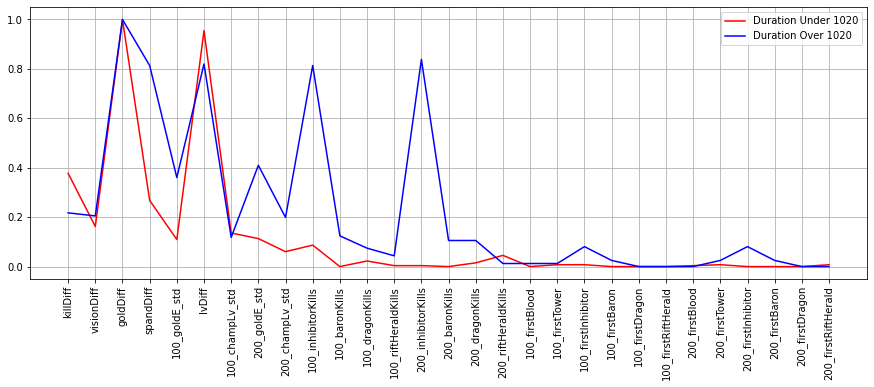

In [128]:
plt.figure(figsize = (15,5))

plt.plot(lg_fi.index, lg_fi[0], 'r-', label='Duration Under 1020')
plt.plot(lg2_fi.index, lg2_fi[0], 'b-', label = 'Duration Over 1020')
plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

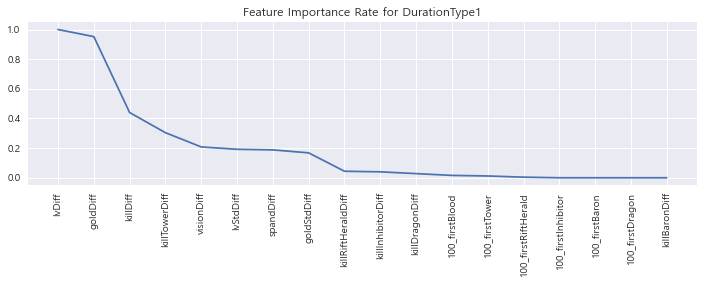

In [89]:
# durationType 1 (under 1020) 의 피쳐중요도 순 나열

plt.figure(figsize = (12,3))
plt.plot(lg_fi[0].sort_values(ascending=False).index, lg_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
plt.title('Feature Importance Rate for DurationType1')
# plt.grid()
plt.show()

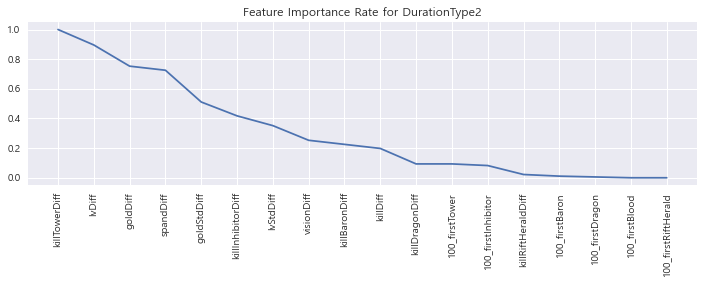

In [90]:
# durationType 2 (over 1020) 의 피쳐중요도 순 나열
plt.figure(figsize = (12,3))
plt.plot(lg2_fi[0].sort_values(ascending=False).index, lg2_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Rate for DurationType2')
plt.show()

## 2차 모델링
 * 1차 모델링 결과의 변수 중요도에 따라 변수 축소 후 재 모델링
 
 ### 변수 중요도 별로 변수 축소

In [97]:
light_fi_concat = pd.concat([light_fi, light2_fi], axis = 1)
light_fi_concat.columns = ['type1', 'type2']

In [98]:
re_cols = light_fi_concat[(light_fi_concat['type1'] > 0.05) &(light_fi_concat['type2'] >0.05)].index 
light_fi_concat.loc[re_cols,]

type1  type2
killDiff        0.44   0.20
visionDiff      0.21   0.25
goldDiff        0.95   0.75
spandDiff       0.19   0.73
goldStdDiff     0.17   0.51
lvDiff          1.00   0.90
lvStdDiff       0.19   0.35
killTowerDiff   0.30   1.00

In [99]:
X1_re = X1[re_cols]
X1_re_train, X1_re_test, y1_train, y1_test = train_test_split(X1_re, y1, test_size=0.3, random_state=910)

In [100]:
lgbm = LGBMClassifier()

parameters = {
            'max_depth' : [3],
            'num_leaves' : [32,64,128],
            'min_data_in_leaf' : [1,5,10],
            'colsample_bytree' : [0.8, 1],
            'n_estimators' : [100,150]}

GS_light_re = GridSearchCV(lgbm, parameters, cv = 10, scoring = 'accuracy')
GS_light_re.fit(X1_re_train, y1_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1], 'max_depth': [3],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 150],
                         'num_leaves': [32, 64, 128]},
             scoring='accuracy')

In [139]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GS_light_re.cv_results_['mean_test_score']
stds = GS_light_re.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_light_re.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 32}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 64}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 128}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 32}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 64}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 128}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 32}
1.000 (+/-0.002) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 64

#### lightGBM durationType 1 모델링 결과

In [101]:
print(GS_light_re.best_params_)
print(GS_light_re.best_score_)

{'colsample_bytree': 1, 'max_depth': 3, 'min_data_in_leaf': 10, 'n_estimators': 100, 'num_leaves': 32}
0.9994340511799121


In [102]:
pred = GS_light_re.predict(X1_re_test)

print(classification_report(y1_test, pred))
print(confusion_matrix(y1_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2248
         1.0       1.00      1.00      1.00      2296

    accuracy                           1.00      4544
   macro avg       1.00      1.00      1.00      4544
weighted avg       1.00      1.00      1.00      4544

[[2247    1]
 [   1 2295]]


In [103]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[2247,1],[1,2295]])

Predicted      
                  Win  Lose
Actual Win       2247     1
       Lose         1  2295

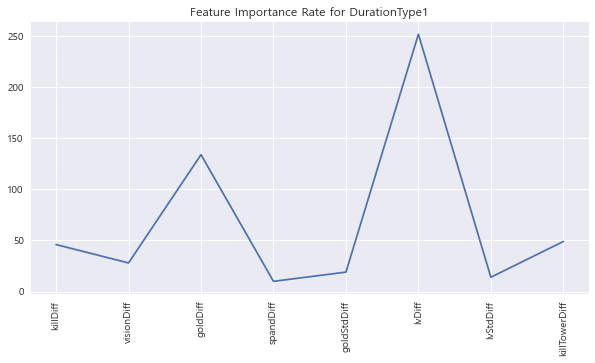

In [112]:
plt.figure(figsize = (10,5))
plt.plot(X1_re.columns, GS_light_re.best_estimator_.feature_importances_)

plt.xticks(rotation = 90)
plt.title('Feature Importance Rate for DurationType1')
plt.show()

In [108]:
X2_re = X2[re_cols]
X2_re_train, X2_re_test, y2_train, y2_test = train_test_split(X2_re, y2, test_size=0.3, random_state=910)

In [109]:
lgbm = LGBMClassifier()

parameters = {
            'max_depth' : [3],
            'num_leaves' : [32,64,128],
            'min_data_in_leaf' : [1,5,10],
            'colsample_bytree' : [0.8, 1],
            'n_estimators' : [100,150]}

GS_light2_re = GridSearchCV(lgbm, parameters, cv = 10, scoring = 'accuracy')
GS_light2_re.fit(X2_re_train, y2_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1], 'max_depth': [3],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 150],
                         'num_leaves': [32, 64, 128]},
             scoring='accuracy')

#### lightGBM durationType 2 모델링 결과

In [110]:
print(GS_light2_re.best_params_)
print(GS_light2_re.best_score_)

{'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 150, 'num_leaves': 32}
0.9936100506017761


In [111]:
pred = GS_light2_re.predict(X2_re_test)

print(classification_report(y2_test, pred))
print(confusion_matrix(y2_test, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     11653
         1.0       0.99      0.99      0.99     11353

    accuracy                           0.99     23006
   macro avg       0.99      0.99      0.99     23006
weighted avg       0.99      0.99      0.99     23006

[[11584    69]
 [   61 11292]]


In [115]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[11584,69],[61,11292]])

Predicted       
                  Win   Lose
Actual Win      11584     69
       Lose        61  11292

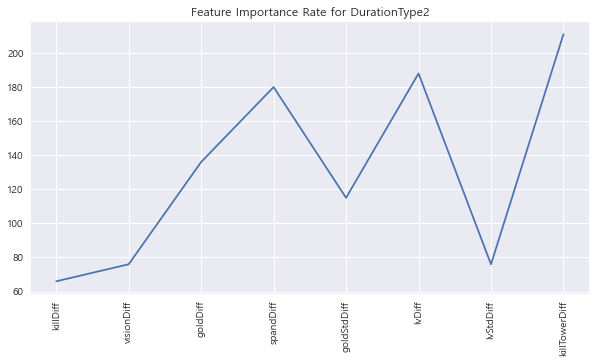

In [113]:
plt.figure(figsize = (10,5))
plt.plot(X2_re.columns, GS_light2_re.best_estimator_.feature_importances_)

plt.xticks(rotation = 90)
plt.title('Feature Importance Rate for DurationType2')
plt.show()

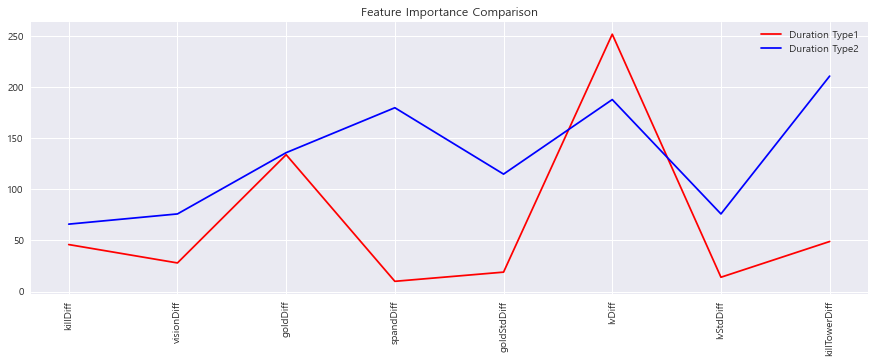

In [119]:
plt.figure(figsize = (15,5))

plt.plot(X1_re.columns, GS_light_re.best_estimator_.feature_importances_, 'r-', label='Duration Type1')
plt.plot(X2_re.columns, GS_light2_re.best_estimator_.feature_importances_, 'b-', label='Duration Type2')
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Comparison')
plt.legend()
plt.show()

In [121]:
light_re_fi= pd.DataFrame(GS_light_re.best_estimator_.feature_importances_, index= X1_re.columns)
light_re_fi[0] = light_re_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

light2_re_fi = pd.DataFrame(GS_light2_re.best_estimator_.feature_importances_, index= X2_re.columns)
light2_re_fi[0] = light2_re_fi[0].transform(lambda x : (x - x.min()) / (x.max() - x.min()))

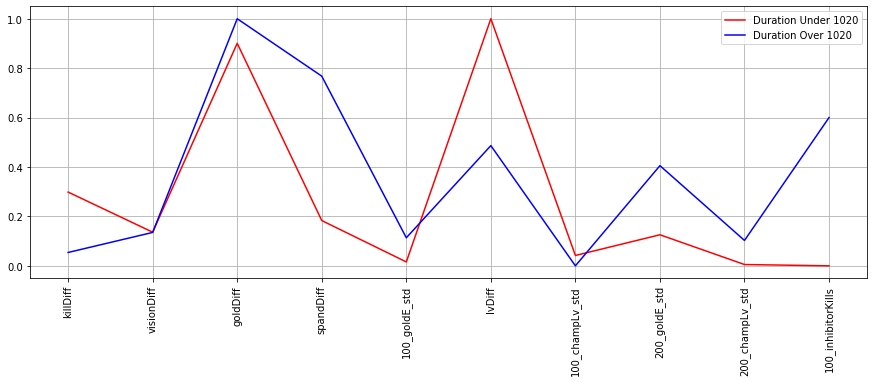

In [149]:
plt.figure(figsize = (15,5))

plt.plot(light_re_fi.index, light_re_fi[0], 'r-', label='Duration Under 1020')
plt.plot(light2_re_fi.index, light2_re_fi[0], 'b-', label = 'Duration Over 1020')
plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

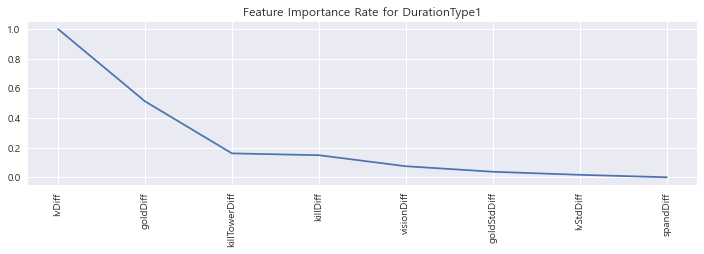

In [123]:
# durationType 1 (under 1020) 의 피쳐중요도 순 나열

plt.figure(figsize = (12,3))
plt.plot(light_re_fi[0].sort_values(ascending=False).index, light_re_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Rate for DurationType1')
plt.show()

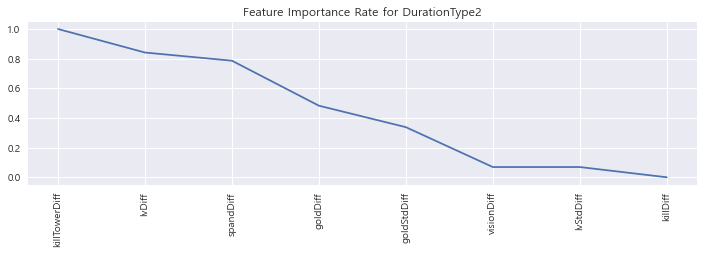

In [124]:
# durationType 2 (over 1020) 의 피쳐중요도 순 나열

plt.figure(figsize = (12,3))
plt.plot(light2_re_fi[0].sort_values(ascending=False).index, light2_re_fi[0].sort_values(ascending = False))
plt.xticks(rotation = 90)
# plt.grid()
plt.title('Feature Importance Rate for DurationType2')
plt.show()

## 결론

 * 경기 종료 후의 데이터를 가지고 승패를 가려낼 경우 높은 확률로 경기 결과를 판별해낼 수 있다.
 * 이때 주요한 변수는 양측의 챔피언 레벨 / 획득한 골드 / 전투의 결과인 킬 수로 판단된다.
 * 경기 시간이 짧을 수록 주요 변수의 양팀 간 차이가 크게 나타나고, 경기 시간이 길어질 수록 주요 변수의 영향력은 다소 줄어드는 것으로 보인다.

## (부록_1) 챔피언 선호도 분석

In [156]:
raw_df.head()

gameCreation  gameDuration        gameId gameMode      gameType  \
0  1.585155e+12        1323.0  4.247263e+09  CLASSIC  MATCHED_GAME   
1  1.585152e+12        1317.0  4.247156e+09  CLASSIC  MATCHED_GAME   
2  1.585059e+12         932.0  4.243963e+09  CLASSIC  MATCHED_GAME   
3  1.584978e+12        2098.0  4.241678e+09  CLASSIC  MATCHED_GAME   
4  1.584973e+12        2344.0  4.241539e+09  CLASSIC  MATCHED_GAME   

     gameVersion  mapId                              participantIdentities  \
0  10.6.314.4405   11.0  [{'participantId': 1, 'player': {'platformId':...   
1  10.6.314.4405   11.0  [{'participantId': 1, 'player': {'platformId':...   
2  10.6.313.8894   11.0  [{'participantId': 1, 'player': {'platformId':...   
3  10.6.313.8894   11.0  [{'participantId': 1, 'player': {'platformId':...   
4  10.6.313.8894   11.0  [{'participantId': 1, 'player': {'platformId':...   

                                        participants platformId  queueId  \
0  [{'participantId': 1, 'teamId': 100, 'champion...         KR    420.0   
1  [{'participantId': 1, 'teamId': 100, 'champion...         KR    420.0   
2  [{'participantId': 1, 'teamId': 100, 'champion...         KR    420.0   
3  [{'participantId': 1, 'teamId': 100, 'champion...         KR    420.0   
4  [{'participantId': 1, 'teamId': 100, 'champion...         KR    420.0   

   seasonId status.message  status.status_code  
0      13.0            NaN                 NaN  
1      13.0            NaN                 NaN  
2      13.0            NaN                 NaN  
3      13.0            NaN                 NaN  
4      13.0            NaN                 NaN

In [172]:
pd.DataFrame(raw_df['participants'][1])

participantId  teamId  championId  spell1Id  spell2Id  \
0              1     100         236        14         4   
1              2     100         245        11         4   
2              3     100         350         7         3   
3              4     100         110        21         4   
4              5     100          57         4        12   
5              6     200         235        21         4   
6              7     200         126         4        12   
7              8     200         517         4        11   
8              9     200          58         4        14   
9             10     200          15         4         7   

                                               stats  \
0  {'participantId': 1, 'win': True, 'item0': 242...   
1  {'participantId': 2, 'win': True, 'item0': 203...   
2  {'participantId': 3, 'win': True, 'item0': 317...   
3  {'participantId': 4, 'win': True, 'item0': 314...   
4  {'participantId': 5, 'win': True, 'item0': 105...   
5  {'participantId': 6, 'win': False, 'item0': 30...   
6  {'participantId': 7, 'win': False, 'item0': 31...   
7  {'participantId': 8, 'win': False, 'item0': 31...   
8  {'participantId': 9, 'win': False, 'item0': 30...   
9  {'participantId': 10, 'win': False, 'item0': 1...   

                                            timeline  
0  {'participantId': 1, 'creepsPerMinDeltas': {'1...  
1  {'participantId': 2, 'creepsPerMinDeltas': {'1...  
2  {'participantId': 3, 'creepsPerMinDeltas': {'1...  
3  {'participantId': 4, 'creepsPerMinDeltas': {'1...  
4  {'participantId': 5, 'creepsPerMinDeltas': {'1...  
5  {'participantId': 6, 'creepsPerMinDeltas': {'1...  
6  {'participantId': 7, 'creepsPerMinDeltas': {'1...  
7  {'participantId': 8, 'creepsPerMinDeltas': {'1...  
8  {'participantId': 9, 'creepsPerMinDeltas': {'1...  
9  {'participantId': 10, 'creepsPerMinDeltas': {'...

In [159]:
champ_df = pd.read_json('http://ddragon.leagueoflegends.com/cdn/11.15.1/data/en_US/champion.json')
champ_df['data']

Aatrox     {'version': '11.15.1', 'id': 'Aatrox', 'key': ...
Ahri       {'version': '11.15.1', 'id': 'Ahri', 'key': '1...
Akali      {'version': '11.15.1', 'id': 'Akali', 'key': '...
Akshan     {'version': '11.15.1', 'id': 'Akshan', 'key': ...
Alistar    {'version': '11.15.1', 'id': 'Alistar', 'key':...
                                 ...                        
Zed        {'version': '11.15.1', 'id': 'Zed', 'key': '23...
Ziggs      {'version': '11.15.1', 'id': 'Ziggs', 'key': '...
Zilean     {'version': '11.15.1', 'id': 'Zilean', 'key': ...
Zoe        {'version': '11.15.1', 'id': 'Zoe', 'key': '14...
Zyra       {'version': '11.15.1', 'id': 'Zyra', 'key': '1...
Name: data, Length: 156, dtype: object

In [197]:
pd.DataFrame([champ_df['data'][0]


0       1
0  266  Aatrox

In [206]:
champ_list = pd.DataFrame(columns = ['key', 'id'])

for i in range(0,len(champ_df['data'])) :
    temp = pd.DataFrame([champ_df['data'][i].get('key'), champ_df['data'][i].get('id')]).transpose()
    temp.columns = champ_list.columns
    champ_list = champ_list.append(temp)
    

In [214]:
champ_list = champ_list.reset_index(drop=True)
champ_list.to_csv('data/champ_list.csv')

In [215]:
champ_list

key       id
0    266   Aatrox
1    103     Ahri
2     84    Akali
3    166   Akshan
4     12  Alistar
..   ...      ...
151  238      Zed
152  115    Ziggs
153   26   Zilean
154  142      Zoe
155  143     Zyra

[156 rows x 2 columns]

In [282]:
raw_df = raw_df.reset_index(drop=True)

In [249]:
champ_dummy = pd.DataFrame(columns= champ_list['key'].sort_values().values)
champ_dummy

Empty DataFrame
Columns: [1, 10, 101, 102, 103, 104, 105, 106, 107, 11, 110, 111, 112, 113, 114, 115, 117, 119, 12, 120, 121, 122, 126, 127, 13, 131, 133, 134, 136, 14, 141, 142, 143, 145, 147, 15, 150, 154, 157, 16, 161, 163, 164, 166, 17, 18, 19, 2, 20, 201, 202, 203, 21, 22, 222, 223, 23, 234, 235, 236, 238, 24, 240, 245, 246, 25, 254, 26, 266, 267, 268, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 350, 36, 360, 37, 38, 39, 4, 40, 41, 412, 42, 420, 421, 427, 429, 43, 432, 44, 45, ...]
Index: []

[0 rows x 156 columns]

In [274]:
champ_dummy2 = champ_dummy.copy().append(pd.DataFrame(np.zeros((1,156)), columns = champ_dummy.columns))
champ_dummy2

1   10  101  102  103  104  105  106  107   11  ...  876  887   89    9  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    90   91   92   96   98   99  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 156 columns]

In [285]:
pd.DataFrame(raw_df['participants'][0])

participantId  teamId  championId  spell1Id  spell2Id  \
0              1     100           7         1         4   
1              2     100         350         3         7   
2              3     100         266         4        12   
3              4     100         517         4        11   
4              5     100         110         4        21   
5              6     200         235         1         4   
6              7     200          81         7         4   
7              8     200         127         4        12   
8              9     200          84         4        12   
9             10     200         421        11         4   

                                               stats  \
0  {'participantId': 1, 'win': False, 'item0': 20...   
1  {'participantId': 2, 'win': False, 'item0': 31...   
2  {'participantId': 3, 'win': False, 'item0': 10...   
3  {'participantId': 4, 'win': False, 'item0': 31...   
4  {'participantId': 5, 'win': False, 'item0': 20...   
5  {'participantId': 6, 'win': True, 'item0': 386...   
6  {'participantId': 7, 'win': True, 'item0': 314...   
7  {'participantId': 8, 'win': True, 'item0': 203...   
8  {'participantId': 9, 'win': True, 'item0': 314...   
9  {'participantId': 10, 'win': True, 'item0': 0,...   

                                            timeline  
0  {'participantId': 1, 'creepsPerMinDeltas': {'1...  
1  {'participantId': 2, 'creepsPerMinDeltas': {'1...  
2  {'participantId': 3, 'creepsPerMinDeltas': {'1...  
3  {'participantId': 4, 'creepsPerMinDeltas': {'1...  
4  {'participantId': 5, 'creepsPerMinDeltas': {'1...  
5  {'participantId': 6, 'creepsPerMinDeltas': {'1...  
6  {'participantId': 7, 'creepsPerMinDeltas': {'1...  
7  {'participantId': 8, 'creepsPerMinDeltas': {'1...  
8  {'participantId': 9, 'creepsPerMinDeltas': {'1...  
9  {'participantId': 10, 'creepsPerMinDeltas': {'...

In [301]:
comb_df = raw_df[(raw_df['gameMode'] == 'CLASSIC') & (raw_df['mapId'] == 11)][['gameDuration', 'participants']].copy().reset_index(drop=True)

In [305]:
comb_df['durationType']= comb_df['gameDuration'].map(classify_durationType)
comb_df['durationType'].value_counts()

2    76492
1    15128
0     1231
Name: durationType, dtype: int64

In [322]:
comb_df

gameDuration                                       participants  \
0            1323.0  [{'participantId': 1, 'teamId': 100, 'champion...   
1            1317.0  [{'participantId': 1, 'teamId': 100, 'champion...   
2             932.0  [{'participantId': 1, 'teamId': 100, 'champion...   
3            2098.0  [{'participantId': 1, 'teamId': 100, 'champion...   
4            2344.0  [{'participantId': 1, 'teamId': 100, 'champion...   
...             ...                                                ...   
92846         934.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92847        1418.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92848         933.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92849        1544.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92850        2090.0  [{'participantId': 1, 'teamId': 100, 'champion...   

       durationType  100_win  
0                 2        0  
1                 2        0  
2                 1        0  
3                 2        0  
4                 2        0  
...             ...      ...  
92846             1        0  
92847             2        0  
92848             1        0  
92849             2        0  
92850             2        0  

[92851 rows x 4 columns]

In [384]:
pd.DataFrame(comb_df['participants'][41])['stats'].apply(pd.Series)['win'][0]

True

In [385]:
win_list = []
for i in range(0, comb_df.shape[0]) :
    win_list.append(pd.DataFrame(comb_df['participants'][i])['stats'].apply(pd.Series)['win'][0])

In [386]:
win_list = pd.DataFrame(win_list).rename(columns= { 0 : '100_win'})

In [387]:
win_list.value_counts()

100_win
False      46979
True       45872
dtype: int64

In [344]:
comb_df

gameDuration                                       participants  \
0            1323.0  [{'participantId': 1, 'teamId': 100, 'champion...   
1            1317.0  [{'participantId': 1, 'teamId': 100, 'champion...   
2             932.0  [{'participantId': 1, 'teamId': 100, 'champion...   
3            2098.0  [{'participantId': 1, 'teamId': 100, 'champion...   
4            2344.0  [{'participantId': 1, 'teamId': 100, 'champion...   
...             ...                                                ...   
92846         934.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92847        1418.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92848         933.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92849        1544.0  [{'participantId': 1, 'teamId': 100, 'champion...   
92850        2090.0  [{'participantId': 1, 'teamId': 100, 'champion...   

       durationType  100_win  
0                 2    False  
1                 2    False  
2                 1    False  
3                 2    False  
4                 2    False  
...             ...      ...  
92846             1    False  
92847             2    False  
92848             1    False  
92849             2    False  
92850             2    False  

[92851 rows x 4 columns]

In [359]:
champs = pd.DataFrame()

for i in range(0, comb_df.shape[0]) : 
    
    temp_100 = champ_dummy2.copy()
    temp_200 = champ_dummy2.copy()

    part = pd.DataFrame(comb_df['participants'][i])
    
    for j in range(0, 5) :     
        key = part[part['teamId'] == 100]['championId'][j].astype('str')
        temp_100[key] += 1 

    temp_100.columns = '100_'+temp_100.columns
    
    for k in range(5, 10) :     
        key = part[part['teamId'] == 200]['championId'][k].astype('str')
        temp_200[key] += 1 

    temp_200.columns = '200_'+temp_200.columns
    
    temp = pd.concat([temp_100, temp_200], axis = 1)
    champs = champs.append(temp)

In [360]:
champs

100_1  100_10  100_101  100_102  100_103  100_104  100_105  100_106  \
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
..    ...     ...      ...      ...      ...      ...      ...      ...   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      1.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   

    100_107  100_11  ...  200_876  200_887  200_89  200_9  200_90  200_91  \
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
..      ...     ...  ...      ...      ...     ...    ...     ...     ...   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
0       0.0     0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   

    200_92  200_96  200_98  200_99  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
..     ...     ...     ...     ...  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  
0      0.0     0.0     0.0     0.0  

[92851 rows x 312 columns]

In [365]:
comb_df.head()

gameDuration                                       participants  \
0        1323.0  [{'participantId': 1, 'teamId': 100, 'champion...   
1        1317.0  [{'participantId': 1, 'teamId': 100, 'champion...   
2         932.0  [{'participantId': 1, 'teamId': 100, 'champion...   
3        2098.0  [{'participantId': 1, 'teamId': 100, 'champion...   
4        2344.0  [{'participantId': 1, 'teamId': 100, 'champion...   

   durationType  100_win  
0             2    False  
1             2    False  
2             1    False  
3             2    False  
4             2    False

In [368]:
champs = champs.reset_index(drop=True)

In [394]:
champ_pick = pd.concat([comb_df, champs], axis = 1).drop(['participants', 'gameDuration'], axis = 1)
champ_pick.to_csv('data/champs_pick.csv')

In [388]:
champ_pick['100_win'] = win_list['100_win']

In [395]:
champ_pick.head()

durationType  100_win  100_1  100_10  100_101  100_102  100_103  100_104  \
0             2    False    0.0     0.0      0.0      0.0      0.0      0.0   
1             2     True    0.0     0.0      0.0      0.0      0.0      0.0   
2             1    False    0.0     0.0      0.0      0.0      0.0      0.0   
3             2    False    0.0     0.0      0.0      0.0      0.0      0.0   
4             2     True    0.0     0.0      0.0      0.0      0.0      0.0   

   100_105  100_106  ...  200_876  200_887  200_89  200_9  200_90  200_91  \
0      0.0      0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
1      0.0      0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
2      0.0      0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
3      0.0      0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   
4      0.0      0.0  ...      0.0      0.0     0.0    0.0     0.0     0.0   

   200_92  200_96  200_98  200_99  
0     0.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     0.0  
2     0.0     0.0     0.0     0.0  
3     0.0     0.0     0.0     0.0  
4     0.0     0.0     0.0     0.0  

[5 rows x 314 columns]

In [393]:
champ_pick['100_win'].value_counts()

False    46979
True     45872
Name: 100_win, dtype: int64

In [378]:
champ_pick['100_win'].value_counts()

False    92851
Name: 100_win, dtype: int64

In [631]:
champ_col_100 = champ_pick.iloc[:,2:158].columns
champ_col_200 = champ_pick.iloc[:,158:].columns

rank_columns = [['DurationType1_100_Win','DurationType1_100_Win','DurationType1_100_Lose','DurationType1_100_Lose',
                 'DurationType2_100_Win','DurationType2_100_Win','DurationType2_100_Lose','DurationType2_100_Lose'],
               ['Champ','PickRate','Champ','PickRate','Champ','PickRate','Champ','PickRate']]

In [523]:
champ_col_200

Index(['200_1', '200_10', '200_101', '200_102', '200_103', '200_104',
       '200_105', '200_106', '200_107', '200_11',
       ...
       '200_876', '200_887', '200_89', '200_9', '200_90', '200_91', '200_92',
       '200_96', '200_98', '200_99'],
      dtype='object', length=156)

In [448]:
champ_group = champ_pick.groupby(['durationType','100_win']).sum()
champ_group

100_1  100_10  100_101  100_102  100_103  100_104  \
durationType 100_win                                                      
0            False      3.0     8.0      6.0      5.0      7.0     24.0   
             True       2.0    11.0      4.0     13.0     13.0     20.0   
1            False     31.0   100.0     55.0    124.0    105.0    251.0   
             True      24.0   101.0     42.0     88.0    132.0    221.0   
2            False    129.0   491.0    326.0    526.0    692.0   1365.0   
             True     129.0   447.0    242.0    511.0    693.0   1373.0   

                      100_105  100_106  100_107  100_11  ...  200_876  \
durationType 100_win                                     ...            
0            False       13.0     16.0     10.0    19.0  ...      0.0   
             True         9.0     14.0     11.0     8.0  ...      0.0   
1            False      228.0    108.0    164.0   109.0  ...      0.0   
             True       242.0    144.0    152.0   110.0  ...      0.0   
2            False     1047.0    647.0    789.0   550.0  ...      0.0   
             True      1107.0    650.0    714.0   459.0  ...      0.0   

                      200_887  200_89  200_9  200_90  200_91  200_92  200_96  \
durationType 100_win                                                           
0            False        0.0    36.0    8.0     5.0    32.0     4.0     0.0   
             True         0.0    20.0    6.0     2.0    13.0     2.0     3.0   
1            False        0.0   428.0  108.0    37.0   352.0    61.0    22.0   
             True         0.0   399.0  114.0    39.0   261.0    63.0    29.0   
2            False        0.0  2216.0  597.0   247.0  1574.0   305.0   102.0   
             True         0.0  2184.0  573.0   238.0  1297.0   291.0   101.0   

                      200_98  200_99  
durationType 100_win                  
0            False      10.0     7.0  
             True       13.0    10.0  
1            False     173.0    80.0  
             True      146.0   120.0  
2            False     814.0   496.0  
             True      778.0   596.0  

[6 rows x 312 columns]

In [635]:
rank_100_tb = pd.DataFrame()

for i in range(1, 3) : 
    for j in range(0,2):

        temp = pd.DataFrame(champ_pick[(champ_pick['durationType'] == i) & (champ_pick['100_win'] == j)][champ_col_100].sum().sort_values(ascending=False).head(10)).reset_index()
        temp['index'] = temp['index'].apply(lambda x : champ_list['id'][x.split('_')[1]])
        temp[0] = temp[0].apply(lambda x : x / (champ_pick[(champ_pick['durationType'] == i) & (champ_pick['100_win'] == j)][champ_col_100].sum().sum()/5)*100)

        if rank_100_tb.shape[0] == 0 :
            rank_100_tb = temp
        else :
            rank_100_tb = pd.concat([rank_100_tb, temp], axis = 1)

rank_100_tb.columns = rank_columns
rank_100_tb.index = [['100','100','100','100','100','100','100','100','100','100'], [1,2,3,4,5,6,7,8,9,10]]


###
rank_200_tb = pd.DataFrame()

for i in range(1, 3) : 
    for j in range(0,2):

        temp = pd.DataFrame(champ_pick[(champ_pick['durationType'] == i) & (champ_pick['100_win'] == j)][champ_col_200].sum().sort_values(ascending=False).head(10)).reset_index()
        temp['index'] = temp['index'].apply(lambda x : champ_list['id'][x.split('_')[1]])
        temp[0] = temp[0].apply(lambda x : x / (champ_pick[(champ_pick['durationType'] == i) & (champ_pick['100_win'] == j)][champ_col_200].sum().sum()/5)*100)

        if rank_200_tb.shape[0] == 0 :
            rank_200_tb = temp
        else :
            rank_200_tb = pd.concat([rank_200_tb, temp], axis = 1)

rank_200_tb.columns = rank_columns
rank_200_tb.index = [['200','200','200','200','200','200','200','200','200','200'], [1,2,3,4,5,6,7,8,9,10]]


rank_tb = pd.concat([rank_100_tb, rank_200_tb], axis = 0)

### 경기 결과 별 영웅 선호도 테이블

In [636]:
rank_tb

DurationType1_100_Win            DurationType1_100_Lose             \
                       Champ   PickRate                  Champ   PickRate   
100 1                 LeeSin  18.317757                 LeeSin  18.146112   
    2                 Ezreal  16.528705            MissFortune  14.310029   
    3            MissFortune  14.526035                 Thresh  13.589945   
    4                 Lucian  12.456609                 Ezreal  13.236449   
    5                 Thresh  11.361816                 Lucian  12.123593   
    6                  Sylas  11.308411                  Elise  11.966483   
    7                   Sett  11.054740                   Sett  11.272584   
    8                  Kaisa  10.453939               Aphelios  10.827442   
    9               Aphelios  10.400534                  Senna  10.225190   
    10                  Ekko  10.026702                   Ekko  10.107358   
200 1                 LeeSin  17.489987                 Ezreal  17.766431   
    2            MissFortune  14.352470                 LeeSin  17.439120   
    3                 Thresh  12.990654            MissFortune  14.087457   
    4                 Ezreal  12.696929                 Lucian  11.874836   
    5                  Elise  12.096128                  Sylas  10.840534   
    6                 Lucian  11.495327                  Kaisa  10.631055   
    7                   Sett  11.335113                 Thresh  10.408484   
    8                  Senna  11.161549                   Ekko  10.395391   
    9               Aphelios  10.827770                   Sett  10.212097   
    10                 Sylas   9.612817                  Senna  10.159728   

       DurationType2_100_Win            DurationType2_100_Lose             
                       Champ   PickRate                  Champ   PickRate  
100 1                 LeeSin  18.709794                 LeeSin  18.097263  
    2                 Ezreal  15.302867            MissFortune  15.482328  
    3            MissFortune  14.584942                 Ezreal  15.219240  
    4                 Thresh  12.727086                 Thresh  12.508637  
    5                 Lucian  12.444033                 Lucian  11.602445  
    6                   Sett  11.167722                   Sett  11.278235  
    7                  Kaisa  10.961865               Aphelios  10.704225  
    8               Aphelios  10.894962                  Senna  10.361414  
    9                  Sylas  10.182183                   Ekko  10.114271  
    10                 Senna   9.935155                  Kaisa   9.601382  
200 1                 LeeSin  18.218311                 LeeSin  18.758969  
    2                 Ezreal  15.058412                 Ezreal  15.354770  
    3            MissFortune  14.489733            MissFortune  13.598193  
    4                 Thresh  12.405435                 Thresh  12.516609  
    5                 Lucian  11.618033                 Lucian  12.498007  
    6                   Sett  10.828058                   Sett  10.977943  
    7               Aphelios  10.243940                  Kaisa  10.977943  
    8                  Kaisa  10.159024                  Sylas  10.425193  
    9                   Ekko  10.063816                  Senna  10.241828  
    10                 Senna  10.045803                   Ekko   9.970768

In [438]:
CX1 = champ_pick[champ_pick['durationType'] == 1][champ_col]
Cy1 = champ_pick[champ_pick['durationType'] == 1]['100_win']

CX1_train, CX1_test, Cy1_train, Cy1_test = train_test_split(CX1, Cy1, test_size=0.3, random_state=910)

CX2 = champ_pick[champ_pick['durationType'] == 2][champ_col]
Cy2 = champ_pick[champ_pick['durationType'] == 2]['100_win']

CX2_train, CX2_test, Cy2_train, Cy2_test = train_test_split(CX2, Cy2, test_size=0.3, random_state=910)

In [439]:
lgbm = LGBMClassifier()

parameters = {
            'max_depth' : [3],
            'num_leaves' : [32,64,128],
            'min_data_in_leaf' : [1,5,10],
            'colsample_bytree' : [0.8, 1],
            'n_estimators' : [100,150]}

GS_champ = GridSearchCV(lgbm, parameters, cv = 10, scoring = 'accuracy')
GS_champ.fit(CX1_train, Cy1_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8, 1], 'max_depth': [3],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [100, 150],
                         'num_leaves': [32, 64, 128]},
             scoring='accuracy')

In [440]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GS_champ.cv_results_['mean_test_score']
stds = GS_champ.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GS_champ.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.587 (+/-0.028) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 32}
0.587 (+/-0.028) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 64}
0.587 (+/-0.028) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'num_leaves': 128}
0.585 (+/-0.022) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 32}
0.585 (+/-0.022) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 64}
0.585 (+/-0.022) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 150, 'num_leaves': 128}
0.584 (+/-0.027) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 32}
0.584 (+/-0.027) for {'colsample_bytree': 0.8, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 100, 'num_leaves': 64

In [441]:
print(GS_champ.best_params_)
print(GS_champ.best_score_)

{'colsample_bytree': 1, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 150, 'num_leaves': 32}
0.5907059125936478


In [442]:
pred = GS_champ.predict(CX1_test)

print(classification_report(Cy1_test, pred))
print(confusion_matrix(Cy1_test, pred))

              precision    recall  f1-score   support

       False       0.62      0.53      0.57      2314
        True       0.57      0.65      0.61      2225

    accuracy                           0.59      4539
   macro avg       0.60      0.59      0.59      4539
weighted avg       0.60      0.59      0.59      4539

[[1237 1077]
 [ 772 1453]]


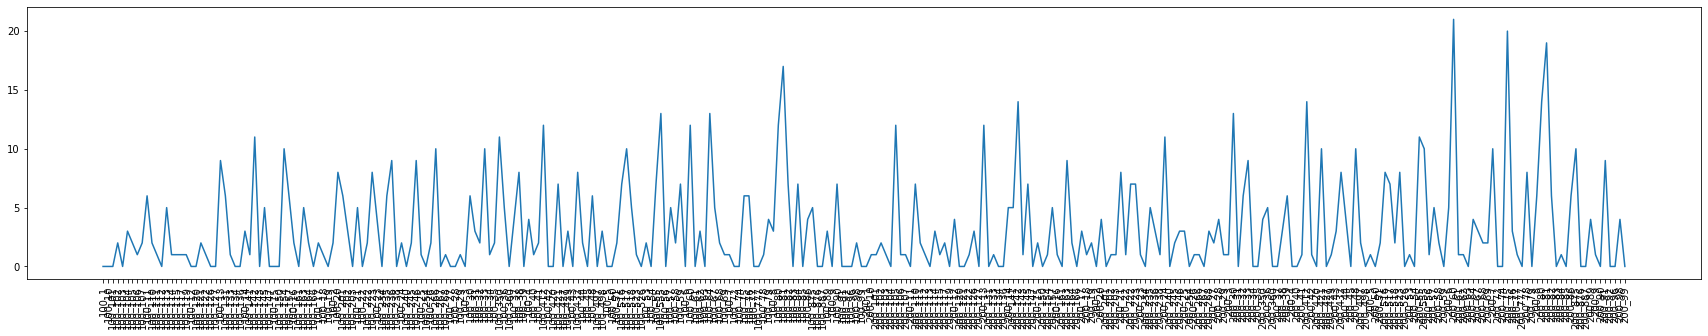

In [447]:
plt.figure(figsize = (30,5))
plt.plot(CX1.columns, GS_champ.best_estimator_.feature_importances_)

plt.xticks(rotation = 90)
plt.show()

In [474]:
champ_col = champ_col.to_list()

In [14]:
# champ_pick.groupby('durationType').sum().plot().bar(y='100_win', x=champ_col)

## (부록_2) Silver 티어 데이터 분석 비교

In [136]:
silver_df = pd.read_csv('data/silver_df_match.csv')
silver_df.shape

(5577, 51)

In [4]:
silver_df.head()

gameId  gameDuration  100_firstBlood  100_firstTower  \
0  4488596337          2426            True           False   
1  4488825341          2152           False           False   
2  4521586060          1685           False            True   
3  4521732452          2323            True            True   
4  4521924468          1193            True            True   

   100_firstInhibitor  100_firstBaron  100_firstDragon  100_firstRiftHerald  \
0               False           False            False                False   
1                True           False            False                False   
2                True            True             True                False   
3                True           False             True                 True   
4               False           False             True                 True   

   100_towerKills  100_inhibitorKills  ...  200_tTimeCC  200_goldE  \
0               9                   2  ...          911      67357   
1               4                   1  ...          662      67161   
2               8                   1  ...          633      45703   
3               7                   1  ...         2318      70884   
4               4                   0  ...          774      28499   

   200_goldE_std  200_goldS  200_minionK  200_nMinionK  200_champLv  \
0        3732.03      63898          776           177        16.60   
1        3397.00      60176          706           208        16.00   
2        2149.95      44695          619           134        13.40   
3        3014.13      61875          703           196        17.00   
4         722.96      26310          352            93        10.00   

   200_champLv_std  200_wardsP  200_wardsK  
0             1.14         104          26  
1             1.58          81          30  
2             1.14          77          24  
3             1.22          86          42  
4             1.00          34           8  

[5 rows x 51 columns]

In [5]:
silver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5577 entries, 0 to 5576
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gameId               5577 non-null   int64  
 1   gameDuration         5577 non-null   int64  
 2   100_firstBlood       5577 non-null   bool   
 3   100_firstTower       5577 non-null   bool   
 4   100_firstInhibitor   5577 non-null   bool   
 5   100_firstBaron       5577 non-null   bool   
 6   100_firstDragon      5577 non-null   bool   
 7   100_firstRiftHerald  5577 non-null   bool   
 8   100_towerKills       5577 non-null   int64  
 9   100_inhibitorKills   5577 non-null   int64  
 10  100_baronKills       5577 non-null   int64  
 11  100_dragonKills      5577 non-null   int64  
 12  100_riftHeraldKills  5577 non-null   int64  
 13  200_firstBlood       5577 non-null   bool   
 14  200_firstTower       5577 non-null   bool   
 15  200_firstInhibitor   5577 non-null   b

In [137]:
silver_df['durationType']= silver_df['gameDuration'].map(classify_durationType)
silver_df['durationType'].value_counts()

2    5170
1     407
Name: durationType, dtype: int64

In [138]:
silver_df.columns

Index(['gameId', 'gameDuration', '100_firstBlood', '100_firstTower',
       '100_firstInhibitor', '100_firstBaron', '100_firstDragon',
       '100_firstRiftHerald', '100_towerKills', '100_inhibitorKills',
       '100_baronKills', '100_dragonKills', '100_riftHeraldKills',
       '200_firstBlood', '200_firstTower', '200_firstInhibitor',
       '200_firstBaron', '200_firstDragon', '200_firstRiftHerald',
       '200_towerKills', '200_inhibitorKills', '200_baronKills',
       '200_dragonKills', '200_riftHeraldKills', '100_win', '100_kill',
       '100_vision', '100_timeCC', '100_tTimeCC', '100_goldE', '100_goldE_std',
       '100_goldS', '100_minionK', '100_nMinionK', '100_champLv',
       '100_champLv_std', '100_wardsP', '100_wardsK', '200_kill', '200_vision',
       '200_timeCC', '200_tTimeCC', '200_goldE', '200_goldE_std', '200_goldS',
       '200_minionK', '200_nMinionK', '200_champLv', '200_champLv_std',
       '200_wardsP', '200_wardsK', 'durationType'],
      dtype='object')

In [139]:
silver_df['killDiff'] = silver_df['100_kill'] - silver_df['200_kill']
silver_df['visionDiff'] = silver_df['100_vision'] - silver_df['200_vision']
silver_df['goldDiff'] = silver_df['100_goldE'] - silver_df['200_goldE']
silver_df['goldStdDiff'] = silver_df['100_goldE_std'] - silver_df['200_goldE_std']
silver_df['spandDiff'] = silver_df['100_goldS'] - silver_df['200_goldS']
silver_df['lvDiff'] = silver_df['100_champLv'] - silver_df['200_champLv']
silver_df['lvStdDiff'] = silver_df['100_champLv_std'] - silver_df['200_champLv_std']
silver_df['killTowerDiff'] = silver_df['100_towerKills'] - silver_df['200_towerKills']
silver_df['killInhibitorDiff'] = silver_df['100_inhibitorKills'] - silver_df['200_inhibitorKills']
silver_df['killBaronDiff'] = silver_df['100_baronKills'] - silver_df['200_baronKills']
silver_df['killDragonDiff'] = silver_df['100_dragonKills'] - silver_df['200_dragonKills']
silver_df['killRiftHeraldDiff'] = silver_df['100_riftHeraldKills'] - silver_df['200_riftHeraldKills']

In [140]:
silver_df1 = silver_df[silver_df['durationType'] == 1].reset_index(drop = True)
silver_df2 = silver_df[silver_df['durationType'] == 2].reset_index(drop = True)

### 기존 데이터로 학습한 모델로 실버 데이터 테스트

In [141]:
scaler = StandardScaler()

x_num = silver_df1[num_col]
scaler.fit(x_num)
x_scaled = scaler.transform(x_num)

x_scaled = pd.DataFrame(x_scaled, index=x_num.index, columns = x_num.columns)

x_cat = silver_df1[cate_col].reset_index(drop = True)

Xs1 = pd.concat([x_scaled,x_cat], axis = 1)
ys1 = silver_df1['100_win']

In [142]:
Xs1_train, Xs1_test, ys1_train, ys1_test = train_test_split(Xs1, ys1, test_size=0.3, random_state = 910)

In [143]:
pred = GS_light.predict(Xs1)

print(classification_report(ys1, pred))
print(confusion_matrix(ys1, pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       182
        True       1.00      1.00      1.00       225

    accuracy                           1.00       407
   macro avg       1.00      1.00      1.00       407
weighted avg       1.00      1.00      1.00       407

[[182   0]
 [  0 225]]


In [156]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[182,0],[0,225]])

Predicted     
                  Win Lose
Actual Win        182    0
       Lose         0  225

In [144]:
scaler = StandardScaler()

x_num = silver_df2[num_col]
scaler.fit(x_num)
x_scaled = scaler.transform(x_num)

x_scaled = pd.DataFrame(x_scaled, index=x_num.index, columns = x_num.columns)

x_cat = silver_df2[cate_col].reset_index(drop = True)

Xs2 = pd.concat([x_scaled,x_cat], axis = 1)
ys2 = silver_df2['100_win']

In [145]:
pred = GS_light2.predict(Xs2)

print(classification_report(ys2, pred))
print(confusion_matrix(ys2, pred))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2481
        True       0.99      0.99      0.99      2689

    accuracy                           0.99      5170
   macro avg       0.99      0.99      0.99      5170
weighted avg       0.99      0.99      0.99      5170

[[2464   17]
 [  33 2656]]


In [157]:
pd.DataFrame(index=[['Actual', 'Actual'], ['Win','Lose']], columns=[['Predicted','Predicted'],['Win','Lose']], data = [[2464,17],[33,2656]])

Predicted      
                  Win  Lose
Actual Win       2464    17
       Lose        33  2656

### Silver Rank 데이터 시각화

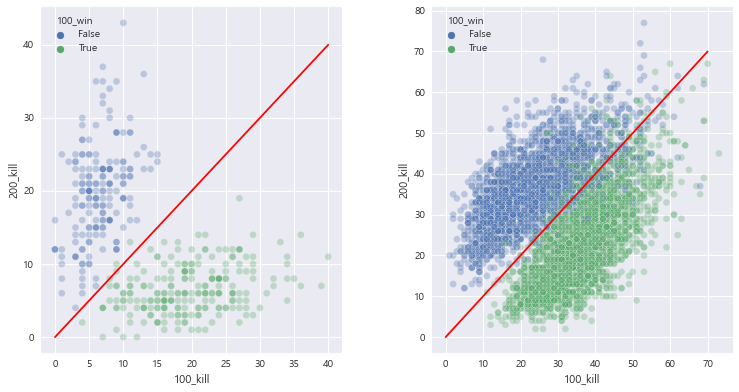

In [146]:
# 양편 kill 대비 승리여부

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = silver_df1, x='100_kill', y='200_kill', hue='100_win', alpha = 0.3)
plt.plot([0, 40], [0,40], 'r-')


plt.subplot(122)
_ = sns.scatterplot(data = silver_df2, x='100_kill', y='200_kill', hue='100_win', alpha = 0.3)
plt.plot([0, 70], [0,70], 'r-')

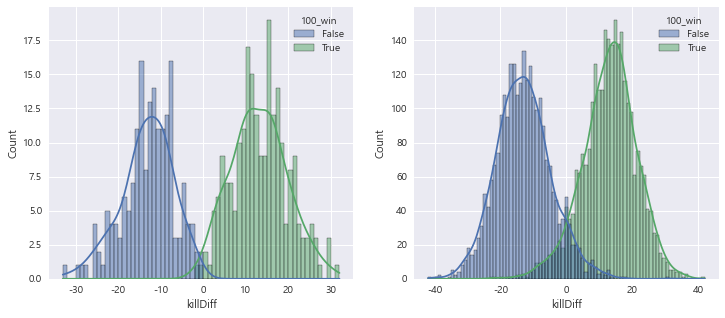

In [151]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = silver_df1, x='killDiff', hue= '100_win', kde = True, binwidth=1)

plt.subplot(122)
_ = sns.histplot(data = silver_df2, x='killDiff', hue= '100_win', kde = True, bins = 85)

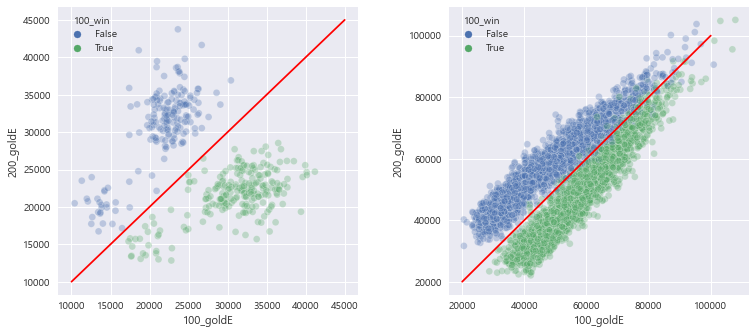

In [152]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = silver_df1, x='100_goldE', y='200_goldE', hue='100_win', alpha = 0.3)
plt.plot([10000, 45000], [10000,45000], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = silver_df2, x='100_goldE', y='200_goldE', hue='100_win', alpha = 0.3)
plt.plot([20000, 100000], [20000,100000], 'r-')

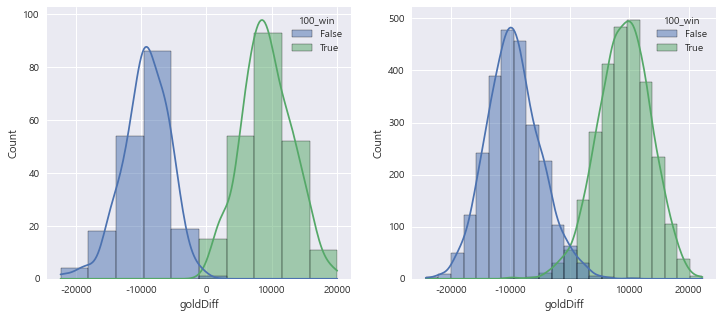

In [153]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = silver_df1, x='goldDiff', hue= '100_win', kde = True)

plt.subplot(122)
_ = sns.histplot(data = silver_df2, x='goldDiff', hue= '100_win', kde = True)

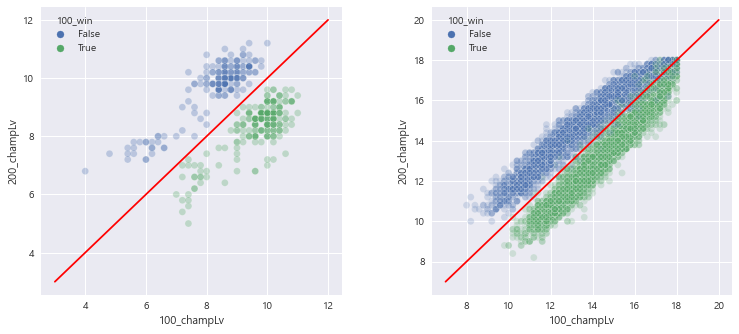

In [154]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.subplots_adjust(left=0.2, bottom=0.1, right=1, top=0.9, wspace=0.3, hspace=0.2)
_ = sns.scatterplot(data = silver_df1, x='100_champLv', y='200_champLv', hue='100_win', alpha = 0.3)
plt.plot([3, 12], [3, 12], 'r-')

plt.subplot(122)
_ = sns.scatterplot(data = silver_df2, x='100_champLv', y='200_champLv', hue='100_win', alpha = 0.2)
plt.plot([7, 20], [7,20], 'r-')

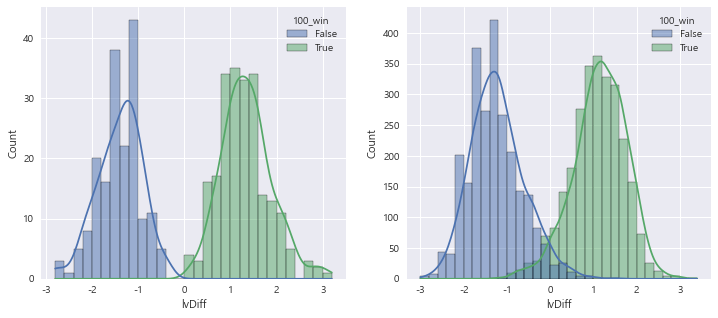

In [155]:
plt.figure(figsize = (12,5))

plt.subplot(121)
_ = sns.histplot(data = silver_df1, x='lvDiff', hue= '100_win', kde = True, binwidth = 0.2)

plt.subplot(122)
_ = sns.histplot(data = silver_df2, x='lvDiff', hue= '100_win', kde = True,  binwidth = 0.2)